# Information diffusion on X (formerly Twitter): a model comparison approach

This notebook is the accompanying code of my master's thesis project. You can find the manuscript on my Github as a PDF.

Author: Ekin Derdiyok

Email: ekin.derdiyok@icloud.com

Github: https://github.com/ekinderdiyok/information-diffusion-on-twitter

Affiliation: M.Sc. in Cognitive Neuroscience (MCNB), Fachbereich Erziehungswissenschaft und Psychologie, Freie Universität Berlin

Date: April 1, 2024


## Table of contents
1. [Import](#import)
2. [Function definitions](#function-definitions)
3. [OpenAI API](#openai-api)
4. [Preprocess](#preprocess)
5. [Explore](#explore)
6. [Draw](#draw)
    1. [Retweet network](#retweet-network)
5. [Modeling retweet count](#modeling-retweet-count)
    1. [Null model](#null-model)
    1. [Mean-field model](#mean-field-models)
    2. [SI Model](#si-model)
    3. [IC Model](#ic-model)
    4. [Decaying IC Model](#decaying-ic-model)
    4. [ECDF vs Decaying IC](#ecdf-vs-dec-IC)
6. [Time series analysis](#time-series-analysis)
    1. [ECDF plot](#ecdf-plot)
    2. [Avrami equation](#avrami-equation)
    3. [Logarithmic fit (single)](#logarithmic-fit-single)
    4. [Logarithmic fit (aggregate)](#logarithmic-fit-aggregate)
    5. [Viral vs broadcast](#viral-vs-broadcast)
8. [Interrater agreement](#interrater-agreement)
    1. [Topic](#topic)
    2. [Nature](#nature)
9. [Archive](#archive)

## Import <a class="anchor" id="import"></a>

In [11]:
%matplotlib inline
import random
import datetime
import matplotlib
import math
import sys
import openai # for identfying tweet topics
import pandas as pd
import numpy as np
import networkx as nx # for creating network graphs
import seaborn as sns # for data visualization
import matplotlib.pyplot as plt # for data visualization
import ndlib.models.ModelConfig as mc # for epidemiological models
import ndlib.models.epidemics as ep # for epidemiological models
import scipy.optimize as optimize # For ordinary least squares
from scipy.optimize import minimize_scalar
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from scipy.stats import f_oneway
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

In [12]:
print(f'Python version used in this study is 3.9.13 (main, Aug 25 2022, 18:24:45) [Clang 12.0.0 ]\n')

Python version used in this study is 3.9.13 (main, Aug 25 2022, 18:24:45) [Clang 12.0.0 ]



## Enter your file paths here

In [13]:
# This is where your figures will be saved when calling eval_model().
fig_path = '/Users/ekinderdiyok/Documents/Thesis/Figures/' 

# Input where your files are stored
data_path = '/Users/ekinderdiyok/Documents/Thesis/Data/'

# Needed for tagging topics and determining semantic category 
my_openai_api_key = 'REPLACE ME'

## Plotting settings to match \LaTeX font

In [14]:
plt.rcParams.update({
    'font.size': 12,          # Default font size for text
    'axes.labelsize': 12,     # Font size for x and y axis labels
    'axes.titlesize': 12,     # Font size for titles
    'xtick.labelsize': 12,    # Font size for x-axis ticks
    'ytick.labelsize': 12     # Font size for y-axis ticks
})

# Set the plot style to white background
sns.set_style('white')

# Match LaTeX font
font = {'family' : 'serif',
         'size'   : 12,
         'serif':  'cmr10'
         }
matplotlib.rc('font', **font)

## Function definitions <a class="anchor" id="function-definitions"></a>

In [15]:
def eval_model(input_function, param, data, n_iter, k = None):
    """
    Evaluate a simulation model by comparing simulated and observed retweet counts using various metrics.

    Parameters:
    - input_function (callable): A simulation function to evaluate.
    - param (float or tuple): Parameters required for the simulation function.
    - data (pandas.DataFrame): A DataFrame containing observed retweet counts, indexed by tweet_id.
    - n_iter (int): The number of iterations for the simulation.
    - k (int, optional): A parameter specific to certain simulation functions (default is None).

    Returns:
    - mad (float): Model mean absolute deviation, a measure of the average absolute difference between
                   simulated and observed retweet counts.
    - correlation_coefficient (float): Pearson's correlation coefficient between simulated and observed retweet counts.
    - sims (list): List of simulated retweet counts for each tweet.
    - obss (list): List of observed retweet counts for each tweet.

    Notes:
    - The function iterates over each tweet in the provided data, simulates retweet counts using the specified
      simulation function, and compares the results with the observed retweet counts.
    - The mad is calculated as the sum of absolute differences divided by the number of tweets.
    - Pearson's correlation coefficient measures the linear correlation between simulated and observed retweet counts.
    - The function also generates a scatter plot comparing observed and simulated retweet counts, along with an ideal fit line.

    Example:
    ```python
    mse, corr_coef, _, _ = eval_model(simulate_IC, 0.0055, cascades, n_iter = 5)
    ```

    """
    
    sims = []
    obss = []
    ss = 0
    tweet_ids = data.index.values
    for tweet_id in tweet_ids:
        if input_function.__name__ == 'sim_decaying_IC':
            G = create_G(cascades, tweet_id)
            sim, obs = input_function(G, param, tweet_id, n_iter, k)
        elif input_function.__name__ in ['simulate_SI', 'simulate_IC']:
            G = create_G(cascades, tweet_id)
            sim, obs = input_function(G, param, tweet_id, n_iter)
        elif input_function.__name__ == 'simulate_base_SI':
            sim, obs = input_function(param, tweet_id, n_iter)
       
        sims.append(sim)
        obss.append(obs)

    tad = np.sum(abs(np.array(sims) - np.array(obss))) 
    mad = tad/len(tweet_ids)
    print(f'Model mean absolute deviation is: {mad}')
    
    # Calculate Pearson's correlation coefficient
    correlation_coefficient, p_value = pearsonr(sims, obss)
    print("Pearson's correlation coefficient:", correlation_coefficient)
    print("P-value:", p_value)
    
    # Create a scatter plot
    plt.scatter(obss, sims, marker='o', facecolors='None', edgecolors='gray', label = 'Cascade')

    # Add labels and a title
    plt.xlabel('Observed retweet count',labelpad=20)
    plt.ylabel('Simulated retweet count',labelpad=20)
    plt.title('Observed vs simulated retweet count',pad=20)
    plt.xscale('log')
    plt.yscale('log')

    # Plot the y = x line
    plt.plot([min(obss), max(obss)], [min(obss), max(obss)], linestyle='--', color='red', label='Ideal fit')
    
    # Display a legend
    plt.legend()

    sns.despine()
    
    plt.savefig(fig_path + input_function.__name__ + '_plot.svg', format='svg', bbox_inches='tight')
    plt.savefig(fig_path + input_function.__name__ + '_plot.png', format='png', bbox_inches='tight', dpi = 300)
    
    # Show the plot
    plt.show()

    return mad, correlation_coefficient, sims, obss

In [16]:
def create_G(data, tweet_id):
    """
    Creates a directed graph representing the propagation cascade of a given tweet.

    Parameters:
    - data (pd.DataFrame): A DataFrame containing information about tweets, followers, and retweeters.
    - tweet_id (str): The unique identifier of the tweet for which the propagation graph is to be created.

    Returns:
    - G (nx.DiGraph): A directed graph (NetworkX DiGraph) representing the propagation cascade.

    Algorithm:
    1. Create an empty directed graph G using NetworkX library.
    2. Retrieve information about the original poster and related data.
    3. Iterate through the followers of the original poster and add edges to G.
    4. Extract followers of retweeters from the dataset.
    5. Iterate through the retweeters, adding edges from retweeter to their followers.
    
    Example Usage:
    ```python
    tweet_id = pick_random_tweet_id(cascades)
    G = create_G(cascades, tweet_id)
    inspect_G(G)
    ```

    Note:
    - The function assumes that the input DataFrame 'data' has columns 'user_id', 'followers', and 'retweeters'.
    - 'pick_random_tweet_id' is a function that selects a random tweet_id from a given dataset.
    - 'inspect_G' is a function for visualizing or analyzing the created graph.
    """
    
    # Create an empty directed graph
    G = nx.DiGraph()
    
    # Define nodes
    original_poster = data.loc[tweet_id]  # pd.Series
    followers = original_poster.followers  # list
    
    retweeters = original_poster.retweeters  # list
    followers_of_retweeters = fn[fn.user_id.isin(retweeters)]  # pd.DataFrame
    
    # Iterate through the followers of the original_poster and add edges.
    for follower in followers:
        source = original_poster.user_id  # user_id of original_poster
        target = follower
        G.add_edge(source, target)
    
    # Iterate over retweeters of the original_poster
    for _, retweeter in followers_of_retweeters.iterrows():
        source = retweeter['user_id']
        targets = retweeter['followers']
        
        # Iterate over followers of a single retweeter and add edges.
        for target in targets:
            G.add_edge(source, target)
    
    return G

In [17]:
def pick_random_tweet_id(data):
    """
    Randomly select a tweet_id from the provided dataset.

    Parameters:
    - data (pandas.DataFrame): The dataset containing tweet information.

    Returns:
    - tweet_id (hashable): Randomly chosen tweet_id.

    The function samples a random tweet_id from the given dataset and prints the chosen tweet_id.
    """
    
    # Pick a random tweet id 
    tweet_id = data.sample().index.item() #str
    
    # Print it
    print(f"Randomly chosen tweet_id is: '{tweet_id}'")
    
    return tweet_id

In [18]:
def scale_timestamps(timestamps):
    """
    Scale timestamps by making them start at zero and converting to hours.

    Parameters:
    - timestamps (list of int/float): List of timestamps to be scaled.

    Returns:
    - scaled_timestamps (list of float): Scaled timestamps in hours.

    The function makes timestamps start at zero by subtracting the minimum value,
    then converts the adjusted timestamps to hours. The resulting scaled timestamps
    are returned as a list of floats.
    """
    
    # Make timestamps start at zero
    timestamps = [timestamp - min(timestamps) for timestamp in timestamps]

    # Convert timestamps to hours
    timestamps = [timestamp / 3600 for timestamp in timestamps]

    return timestamps

In [19]:
def create_bootstrap_samples(data, n_bootstrap_samples, n_rows, random_seed):
    """
    Create bootstrap samples from the given dataset.

    Parameters:
    - data (pandas.DataFrame): The dataset to create bootstrap samples from.
    - n_bootstrap_samples (int): Number of bootstrap samples to generate.
    - n_rows (int): Number of rows to include in each bootstrap sample.
    - random_seed (int): Seed for reproducibility.

    Returns:
    - bootstrap_samples (list of pandas.DataFrame): List of bootstrap samples.

    The function generates bootstrap samples by randomly sampling rows from the input dataset
    with replacement. It prints the number of duplicate rows in the first bootstrap sample and
    the total number of bootstrap samples created. The resulting bootstrap samples are returned
    as a list of pandas DataFrames.
    """
    # Set random seed for reproducibility
    np.random.seed(random_seed)

    # Create a bootstrap sample
    bootstrap_samples = [data.sample(n=n_rows, replace=True) for _ in range(n_bootstrap_samples)]

    # Print information about duplicates and number of samples
    print(f'n_rows that are duplicates: {bootstrap_samples[0].index.duplicated().sum()}')
    print(f'{len(bootstrap_samples)} bootstrap samples were created')

    return bootstrap_samples

In [20]:
def inspect_G(G):
    
    original_poster = cascades.loc[tweet_id, 'user_id']
    print(f'The number of nodes in graph G are {G.number_of_nodes()}')
    print(f'The number of edges in graph G are {G.number_of_edges()}')
    print(f"The number of retweets is {cascades.loc[tweet_id, 'n_rts']}")
    print(f'Out-degree of the original poster: {G.out_degree(original_poster)}')
    print(f'In-degree of the original poster: {G.in_degree(original_poster)}')
    print(f"Number of network followers of the original poster: {cascades.loc[tweet_id, 'n_network_followers']}")

    # Extract out-degrees
    out_degrees = list(G.out_degree)
    
    # Extract the second element of each tuple
    second_elements = [tup[1] for tup in out_degrees]

    """ # Draw a histogram
    plt.figure(figsize=(16, 9))  # Set a larger figure size
    plt.hist(second_elements, bins=50, edgecolor='black')
    plt.xlabel('Count of followers')
    plt.ylabel('Frequency')
    plt.title('Number of followers of followers')
    plt.yscale('log')
    plt.show()"""

# OpenAI API <a class="anchor" id="openai-api"></a>

In [12]:
def ident_topic_clust(tweets, api_key=my_openai_api_key, model="gpt-3.5-turbo", max_tokens=300):
    """
    Identify major topic clusters in a collection of tweets using OpenAI GPT-3.5-turbo.

    Parameters:
    - tweets (str): A collection of tweets to analyze for topic clusters.
    - api_key (str, optional): Your OpenAI API key. If not provided, it uses the default value set during API initialization.
    - model (str, optional): OpenAI language model to use. Default is "gpt-3.5-turbo".
    - max_tokens (int, optional): Maximum number of tokens in the generated response. Default is 300.

    Returns:
    - clusters (str): Identified major topic clusters generated by the language model.

    The function sends a request to the OpenAI GPT-3.5-turbo model to identify major topic clusters
    in the provided collection of tweets. It returns the generated clusters as a string.

    Usage:
    1. Provide a collection of tweets as a string to the 'tweets' parameter.
    2. Optionally, provide your OpenAI API key to the 'api_key' parameter. If not provided, the default value is used.
    3. Optionally, specify the OpenAI language model to use with the 'model' parameter. Default is "gpt-3.5-turbo".
    4. Optionally, set the maximum number of tokens in the generated response with the 'max_tokens' parameter. Default is 300.

    Example:
    ```python
    chunks = np.array_split(cascades['text'], 3)
    
    clusters1 = ident_topic_clust(tweets=chunks[0].str.cat(sep=" \n "))
    clusters2 = ident_topic_clust(tweets=chunks[1].str.cat(sep=" \n "))
    clusters3 = ident_topic_clust(tweets=chunks[2].str.cat(sep=" \n "))
    
    print(clusters1)
    print(clusters2)
    print(clusters3)
    ```
    """
    # Set the first part of your prompt
    fixed = """The following is a large collection of tweets about the Nepal 2015 earthquake. Identify major  topic clusters:"""

    # Combine the fixed part of the prompt with the tweet
    prompt = fixed + tweets

    # Set your OpenAI API key
    if api_key is not None:
        openai.api_key = api_key

    # Make a request to the API
    response = openai.ChatCompletion.create(
        model=model,
        temperature=0,
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ],
        max_tokens=max_tokens
    )

    # Extract and return the generated tags
    clusters = response.choices[0]['message']['content']
    return clusters

In [13]:
def ident_tweet_topic(tweet, api_key=my_openai_api_key, model="gpt-3.5-turbo-1106", max_tokens=20):
    
    # Set the first part of your prompt
    fixed = """Only write the name of the topic which fits the following tweet best. Choose one of the following possible answers:
    1. Rescue operations and assistance
    2. Impact, aftermath, death toll
    3. Aftershocks and tremors
    4. International response and international support
    5. Technology, communication, and social media
    6. Controversy, criticism, social and political commentary
    7. Relief efforts, resources, donations, and infrastructure
    8. Faith and prayers
    9. Personal experience, stories, and missing people
    10. The tweet does not fit any of the given topics.
    Following text is the tweet: """
    
    # Combine the fixed part of the prompt with the tweet
    prompt = fixed + tweet
    
    # Set your OpenAI API key
    openai.api_key = api_key

    # Make a request to the API
    response = openai.ChatCompletion.create(
        model=model,
        temperature = 0,
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ],
        max_tokens=max_tokens
    )

    # Extract and return the generated tags
    topic = response.choices[0]['message']['content']
    return topic

In [14]:
def ident_fact_vs_emot(tweet, api_key=my_openai_api_key, model="gpt-3.5-turbo-1106", max_tokens=300):

    # Set your OpenAI API key
    openai.api_key = api_key

    # Set the fixed part of your prompt
    fixed = """Write 0 if the following tweet is a factual tweet. Write 1 if the following tweet is a personal or emotional tweet. Only answer by writing 0 or 1. Here is the tweet: """

    # Combine the fixed part of the prompt with the tweet
    prompt = fixed + tweet

    # Make a request to the API
    response = openai.ChatCompletion.create(
        model=model,
        temperature = 0,
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ],
        max_tokens=max_tokens
    )

    # Extract and return the generated tags
    fact_vs_emot = response.choices[0]['message']['content']
    return fact_vs_emot

# Preprocess <a class="anchor" id="preprocess"></a>

In [33]:
# Split 'cascades' into groups based on the 'topic' column
def split_dataframe_by_category(dataframe, category_column):
    """
    Splits a DataFrame into smaller DataFrames based on a categorical variable.

    Parameters:
        dataframe (pd.DataFrame): The DataFrame to be split.
        category_column (str): The name of the column used for splitting.

    Returns:
        dict: A dictionary where keys are unique values from the specified column,
              and values are the corresponding smaller DataFrames.
    """
    grouped = dataframe.groupby(category_column)
    groups = {}
    for category, group in grouped:
        groups[category] = group
    return groups

In [9]:
def preprocess_data():
    
    """
    Preprocesses data related to tweet cascades, including user series, time series, and followers network.

    Reads data from CSV files, performs cleaning and merging operations,
    and creates additional columns for analysis. The resulting DataFrame is split
    into groups based on the 'topic' column.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame, dict]:
            - cascades (pd.DataFrame): Processed data containing tweet cascade information.
            - fn (pd.DataFrame): Processed followers network data.
            - groups (dict): Dictionary of DataFrames, where keys are unique 'topic' values,
                             and values are corresponding DataFrames.
    """
    
    # Read the user series data from a CSV file
    us = pd.read_csv(data_path + 'userseries.txt', header=None)

    # Split the first column into 'tweet_id' and 'retweeters' columns
    us[['tweet_id', 'retweeters']] = us.iloc[:, 0].str.split(' ', 1, expand=True)

    # Drop the old column and set 'tweet_id' as the index
    us = us[['tweet_id', 'retweeters']]
    us.set_index('tweet_id', inplace=True)

    # Read the time series data from a CSV file
    ts = pd.read_csv(data_path + 'timeseries.txt', header=None)

    # Split the first column into 'tweet_id' and 'timestamps' columns
    ts[['tweet_id', 'timestamps']] = ts.iloc[:, 0].str.split(' ', 1, expand=True)

    # Drop the old column and set 'tweet_id' as the index
    ts = ts[['tweet_id', 'timestamps']]
    ts.set_index('tweet_id', inplace=True)

    # Merge the user series and time series data to get 'retweeters' for each tweet
    cascades = us.merge(ts, left_index=True, right_index=True, how='inner')

    # Clean the 'retweeters' column by replacing multiple whitespaces with a single space
    cascades['retweeters'] = cascades['retweeters'].str.replace(r'\s+', ' ', regex=True)

    # Remove leading and trailing whitespaces from the 'retweeters' column
    cascades['retweeters'] = cascades['retweeters'].str.strip()

    # Calculate the number of retweets (number of words in 'retweeters' column)
    cascades['n_rts'] = cascades['retweeters'].str.count(' ')

    # Split the 'retweeters' column into 'user_id' of the original poster and 'retweeters'
    cascades[['user_id', 'retweeters']] = cascades['retweeters'].str.split(' ', 1, expand=True)

    # Read the followers network data from a CSV file, clean it, and create a 'user_id' column
    fn = pd.read_csv(data_path + 'followers_network.txt',
                     sep=' ', names=['followers'], header=None)
    fn.followers = fn.followers.str.replace(',', ' ')
    fn.followers = fn.followers.str.strip()
    fn['user_id'] = fn['followers'].str.split().str[0]    

    # Count the number of network followers for each user
    fn['n_network_followers'] = fn['followers'].str.count(' ')

    # Reset the index of the 'cascades' dataframe and merge it with the 'fn' dataframe based on 'user_id'
    cascades.reset_index(inplace=True)
    cascades = cascades.merge(fn, how='left', on='user_id')
    cascades = cascades.set_index('tweet_id')

    # Create a 'link' column by combining the Twitter URL and tweet IDs
    cascades['link'] = 'https://twitter.com/anyuser/status/' + cascades.index.values

    # Pick cascades with the highest n_network_followers, drop multiple cascades from a single user.
    cascades = cascades.sort_values(by='n_network_followers',ascending=False)[:5000].drop_duplicates(subset=['user_id'])

    # Filter out tweets with very few rts
    cascades = cascades[cascades.n_rts > 5]

    # Split 'retweeters,' 'followers,' and 'timestamps' columns to lists
    cascades.retweeters = cascades.retweeters.str.split()
    cascades.followers = cascades.followers.str.split()
    cascades.timestamps = cascades.timestamps.str.split()

    # Define a function to convert a list of strings to a list of floats
    def str_list_to_float_list(str_list):
        return [float(x) for x in str_list]

    # Apply the function to the 'timestamps' column
    cascades['timestamps'] = cascades['timestamps'].apply(str_list_to_float_list)
    
    
    # Scale timestamps so they start at 0 and signify hours.
    cascades['scaled_timestamps'] = cascades['timestamps'].apply(scale_timestamps)    

    # Merge with manually created full_text
    full_text = pd.read_csv(data_path + 'cascades.csv', index_col = 'tweet_id', usecols = ['tweet_id','text', 'n_followers','topic','natures'])
    full_text.index = full_text.index.astype('str')
    cascades = cascades.merge(full_text, left_index = True, right_index = True, how = 'left')

    cascades.index.astype('str')

    cascades.dropna(subset='text',inplace=True)

    cascades['length'] = cascades['text'].str.len()

    cascades['natures'] = cascades['natures'].astype(int)
    
    # This section is commented out to save OpenAI fees by not identifying the topics each time.
    """
    tweets = cascades.text
    topics = []
    for tweet in tweets:
        topic = ident_tweet_topic(tweet = tweet)
        topics.append(topic)
        print(topic)

    # Save topics list as a new col in cascades
    cascades['topic'] = topics
    """
    
    # Commented out to save OpenAI API fees. It marks it each tweet as factual (0), emotion (1), failed to classify (2)
    """
    tweets = cascades.text
    natures = []
    for tweet in tweets:
        nature = ident_fact_vs_emot(tweet = tweet)
        natures.append(nature)
        print(nature)

    natures_012 = ["2" if s not in {"0", "1"} else s for s in natures]
    natures_int = [int(x) for x in natures_012]
    print(natures_int)
    cascades['natures'] = natures_int
    cascades.to_csv(data_path + 'cascades.csv')
    """
    
    # Convert 'topic' column to a categorical data type
    cascades['topic'] = cascades['topic'].astype('category')

    # Define a mapping dictionary to merge categories
    category_mapping = {'Aftershocks and tremors': '3. Aftershocks and tremors', 
                    'Impact, aftermath, death toll': '2. Impact, aftermath, death toll', 
                    'Rescue operations and assistance': '1. Rescue operations and assistance',
                    'The tweet fits best with the topic "Faith and prayers."':'8. Faith and prayers',
                    'The tweet fits the topic of "Impact, aftermath, death toll."':'2. Impact, aftermath, death toll',
                    'The tweet fits the topic of "Technology, communication, and social media."':'5. Technology, communication, and social media',
                    'The tweet fits topic 5: Technology, communication, and social media.':'5. Technology, communication, and social media',
                    'Aftershocks and tremors': '3. Aftershocks and tremors',
                    'Relief efforts, resources, donations, and infrastructure':'7. Relief efforts, resources, donations, and infrastructure',
                    'The tweet fits the topic "Faith and prayers."':'8. Faith and prayers',
                    'The tweet fits the topic of "Relief efforts, resources, donations, and infrastructure."':'7. Relief efforts, resources, donations, and infrastructure' }
    
    # Use replace to merge categories based on the mapping
    cascades['topic'] = cascades['topic'].replace(category_mapping)
    
    # Create i_topic for Kappa test
    cascades['i_topic'] = cascades['topic'].str[0]
    cascades['i_topic'].replace('T', 10, inplace=True)

    # Create normalized n_rts
    cascades['n_rts_norm'] = cascades.n_rts / cascades.n_followers
    
    """# Create the MinMaxScaler
    scaler = MinMaxScaler()

    # Reshape the column to make it a 2D array
    cascades['n_rts_norm'] = cascades['n_rts_norm'].values.reshape(-1, 1)

    # Fit and transform the data
    cascades['n_rts_norm'] = scaler.fit_transform(cascades[['n_rts_norm']])"""
    
    groups = split_dataframe_by_category(cascades, 'topic')
    
    fn.followers = fn.followers.str.split() # NEW
    
    return cascades, fn, groups

In [21]:
# Preprocess the data to create 'cascades' dataframe
cascades, fn, groups = preprocess_data()
cascades

,retweeters,timestamps,n_rts,user_id,followers,n_network_followers,link,scaled_timestamps,n_followers,text,topic,natures,length,i_topic,n_rts_norm
tweet_id,,,,,,,,,,,,,,,
591984228121837568,"[2397106153, 2831673248, 2453676953, 520542949...","[1429955271.0, 1429955284.0, 1429955285.0, 142...",162,428333,"[428333, 332885182, 2391585170, 34266989, 6036...",53849,https://twitter.com/anyuser/status/59198422812...,"[0.0, 0.003611111111111111, 0.0038888888888888...",43000.0,#NepalEarthquake -- @CNNImpact now lists way...,"7. Relief efforts, resources, donations, and i...",0,140,7,0.003767
592280118376026113,"[3195732905, 150493886, 2162649559, 391354039,...","[1430026217.0, 1430026268.0, 1430026277.0, 143...",151,742143,"[742143, 3163742796, 2391585170, 1096566492, 3...",50490,https://twitter.com/anyuser/status/59228011837...,"[0.0, 0.014166666666666666, 0.0166666666666666...",17500.0,People are camping outside #NepalEarthquake,"7. Relief efforts, resources, donations, and i...",1,43,7,0.008629
592158743455993856,"[1550821693, 760544600, 1375526088, 42346547, ...","[1429996870.0, 1429996875.0, 1429996914.0, 142...",262,759251,"[759251, 3163742796, 2391585170, 1096566492, 3...",47366,https://twitter.com/anyuser/status/59215874345...,"[0.0, 0.001388888888888889, 0.0122222222222222...",210100.0,Are you searching for someone after the #Nepal...,"9. Personal experience, stories, and missing p...",0,105,9,0.001247
591922467360276480,"[101198777, 2465344748, 2774554965, 456982384,...","[1429941204.0, 1429941218.0, 1429941219.0, 142...",127,18681139,"[18681139, 91962351, 26461628, 972384505, 1132...",22237,https://twitter.com/anyuser/status/59192246736...,"[0.0, 0.0038888888888888888, 0.004166666666666...",4234.0,@priyankachopra Do share this For blood requ...,"7. Relief efforts, resources, donations, and i...",0,105,7,0.029995
592220099156676609,"[3101345671, 1052663983, 18939918, 474868210, ...","[1430012101.0, 1430012146.0, 1430012199.0, 143...",29,134758540,"[134758540, 1132711926, 102717635, 313385516, ...",20612,https://twitter.com/anyuser/status/59222009915...,"[0.0, 0.0125, 0.02722222222222222, 0.039444444...",3263.0,#Makalu 40 climbers from 20 teams are safe in ...,"7. Relief efforts, resources, donations, and i...",0,124,7,0.008888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
592209786940174336,"[1528284492, 2578308889, 173064517, 2649284857...","[1430009325.0, 1430009388.0, 1430009406.0, 143...",11,2455987260,"[2455987260, 346316391, 2372162220, 94853291, ...",274,https://twitter.com/anyuser/status/59220978694...,"[0.0, 0.0175, 0.0225, 0.042222222222222223, 0....",4300000.0,#IAF and #IndianArmy together are conducting o...,4. International response and international su...,0,107,4,0.000003
592168024100110336,"[157542990, 145513817, 3062192240, 33793786, 1...","[1429999211.0, 1429999372.0, 1429999724.0, 142...",7,549679303,"[549679303, 17679507, 2359028480, 2845917181, ...",273,https://twitter.com/anyuser/status/59216802410...,"[0.0, 0.04472222222222222, 0.1425, 0.183888888...",3108.0,Our thoughts and prayers are with #Nepal. #ear...,"7. Relief efforts, resources, donations, and i...",1,53,7,0.002252
591910829194285057,"[2374090597, 437397401, 528039191, 251016927, ...","[1429937745.0, 1429937784.0, 1429937785.0, 142...",29,2375276990,"[2375276990, 142379064, 2375531316, 828068220,...",272,https://twitter.com/anyuser/status/59191082919...,"[0.0, 0.010833333333333334, 0.0111111111111111...",8000000.0,"As much help as they (Nepal) want, we will pro...",4. International response and international su...,0,111,4,0.000004


# Explore  <a class="anchor" id="explore"></a>

In [16]:
def print_start_end():
    
    def convert_twitter_unix_timestamp_to_datetime(twitter_unix_timestamp):
        """
        Converts a Twitter Unix timestamp to a human-readable date and time.

        Args:
            twitter_unix_timestamp (int): The Twitter Unix timestamp to convert.

        Returns:
            str: A string representing the human-readable date and time in the format "YYYY-MM-DD HH:MM:SS".

        Example:
        >>> twitter_unix_timestamp = 1504649200
        >>> convert_twitter_unix_timestamp_to_datetime(twitter_unix_timestamp)
        '2017-09-05 12:20:00'
        """
        try:
            # Convert the Unix timestamp to a datetime object
            tweet_datetime = datetime.datetime.utcfromtimestamp(twitter_unix_timestamp)

            # Format the datetime as a string
            formatted_datetime = tweet_datetime.strftime("%Y-%m-%d %H:%M:%S")

            return formatted_datetime
        except ValueError:
            return "Invalid timestamp"
    
    # Dates of earliest and latest retweets in the dateset
    latest_date = convert_twitter_unix_timestamp_to_datetime(max(max(cascades.timestamps.values)))
    earliest_date = convert_twitter_unix_timestamp_to_datetime(min(min(cascades.timestamps.values)))
    print(f'Earliest date: {earliest_date}')
    print(f'Latest date: {latest_date}')

In [17]:
print(print_start_end())

Earliest date: 2015-04-25 04:23:59
Latest date: 2015-04-27 03:21:56
None


In [18]:
cascades.topic.value_counts()

7. Relief efforts, resources, donations, and infrastructure    229
2. Impact, aftermath, death toll                                98
4. International response and international support             79
6. Controversy, criticism, social and political commentary      58
1. Rescue operations and assistance                             30
8. Faith and prayers                                            30
9. Personal experience, stories, and missing people             27
3. Aftershocks and tremors                                      23
5. Technology, communication, and social media                  19
The tweet does not fit any of the given topics.                 12
Name: topic, dtype: int64

In [19]:
#Inspect a randomly picked graph
tweet_id = pick_random_tweet_id(cascades)
G = create_G(data = cascades, tweet_id = tweet_id)
inspect_G(G)

Randomly chosen tweet_id is: '591930333530042368'
The number of nodes in graph G are 2021
The number of edges in graph G are 2255
The number of retweets is 38
Out-degree of the original poster: 825
In-degree of the original poster: 1
Number of network followers of the original poster: 824


In [20]:
# Compare infectiousness across semantic categories
cascades.groupby('natures')['n_rts_norm'].mean()

natures
0    0.005915
1    0.012769
2    0.004679
Name: n_rts_norm, dtype: float64

In [21]:
cascades['natures'].value_counts()

0    396
1    199
2     10
Name: natures, dtype: int64

In [22]:
# Compare retweet count across two sematic categories

# Select data for the two categories you want to compare
category1_data = cascades[cascades['natures'] == 0]['n_rts']
category2_data = cascades[cascades['natures'] == 1]['n_rts']

# Perform a t-test
t_statistic, p_value = ttest_ind(category1_data, category2_data)

# Calculate degrees of freedom
degrees_of_freedom = (len(category1_data) + len(category2_data) - 2) // 2

# Display results
print(f'T-Statistic: {t_statistic}')
print(f'Degrees of Freedom: {degrees_of_freedom}')
print(f'P-Value: {p_value}')

# Interpret the results
alpha = 0.05  # significance level
if p_value < alpha:
    print('Reject the null hypothesis: There is a significant difference between the two categories.')
else:
    print('Fail to reject the null hypothesis: There is no significant difference between the two categories.')


T-Statistic: 1.6369328264119212
Degrees of Freedom: 296
P-Value: 0.10217504772148811
Fail to reject the null hypothesis: There is no significant difference between the two categories.


In [23]:
# Compare infectiousness across two sematic categories

# Select data for the two categories you want to compare
category1_data = cascades[cascades['natures'] == 0]['n_rts_norm']
category2_data = cascades[cascades['natures'] == 1]['n_rts_norm']

# Perform a t-test
t_statistic, p_value = ttest_ind(category1_data, category2_data)

# Calculate degrees of freedom
degrees_of_freedom = (len(category1_data) + len(category2_data) - 2) // 2

# Display results
print(f'T-Statistic: {t_statistic}')
print(f'Degrees of Freedom: {degrees_of_freedom}')
print(f'P-Value: {p_value}')

# Interpret the results
alpha = 0.05  # significance level
if p_value < alpha:
    print('Reject the null hypothesis: There is a significant difference between the two categories.')
else:
    print('Fail to reject the null hypothesis: There is no significant difference between the two categories.')


T-Statistic: -1.9651759175240293
Degrees of Freedom: 296
P-Value: 0.04986023571908984
Reject the null hypothesis: There is a significant difference between the two categories.


## Draw  <a class="anchor" id="draw"></a>

/var/folders/j6/6k9fmtb55kj1jy3rcgmt4c4h0000gn/T/ipykernel_16815/3040122099.py:15: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(figsize=(8, 8))


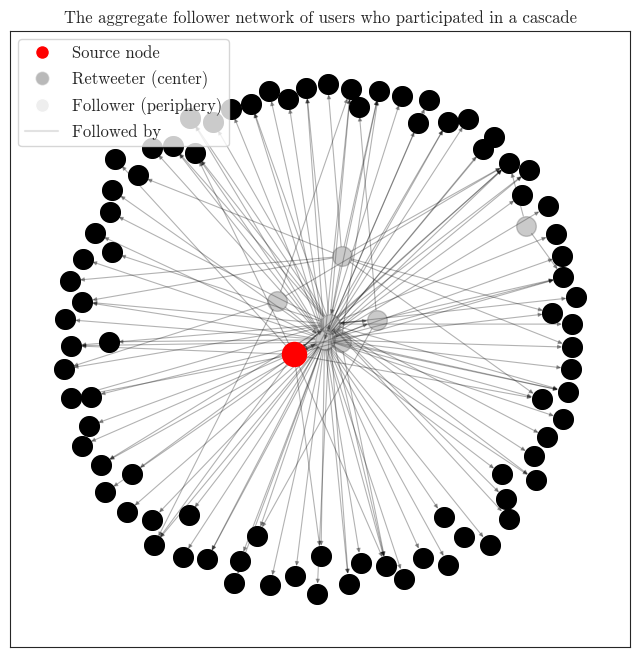

In [17]:
def draw_G(G, original_poster=None, followers=None):
    """
    Visualize a networkx graph with customized settings using draw_networkx.

    Parameters:
    G (networkx.Graph): The graph to be visualized.
    original_poster (str): The ID of the original poster node to be highlighted.
    retweeters (list): List of IDs of retweeter nodes.

    Returns:
    None
        The function displays the graph visualization.
    """
    
    fig, ax = plt.subplots(figsize=(8, 8))
    pos = nx.spring_layout(G) 
    
    #node_color = ['red' if node == original_poster else '#e2e2e2' if node in followers else '#808080' for node in G.nodes()]
    
    nx.draw_networkx(G, pos=pos, ax=ax, with_labels=False, node_size=200, node_color='#505050', font_size=8, font_color='black', alpha=0.3, width=0.8, arrowsize=6)
    
    if original_poster:
        nx.draw_networkx_nodes(G, pos=pos, nodelist=[original_poster], node_size=300, node_color='#ff0000', alpha = 1, label='Original Poster')
    
    if followers:
        nx.draw_networkx_nodes(G, pos=pos, nodelist=followers, node_size=200, node_color='#000000', label='Followers', alpha = 1)

    return None

def remove_reflexive_edges(G):
    reflexive_edges = [(u, v) for u, v in G.edges() if u == v]
    G.remove_edges_from(reflexive_edges)
    
    return G

def select_nodes_to_exc(G):
    # Find nodes with no outdegree
    no_outdegree_nodes = [node for node in G.nodes if G.out_degree(node) == 0]

    # Randomly sample half of the nodes with no outdegree
    sampled_nodes = random.sample(no_outdegree_nodes, k=int(0.97 * len(no_outdegree_nodes)))

    return sampled_nodes

# A cascade with low n_network_followers and elaborate network structure is cherry-picked.
min_index = '592275479916220416'
#min_index = '592602977656971264' other figures in the paper
#min_index = '591905536641110016' other figures in the paper
#min_index = '591934338540838913' other figures in the paper
#min_index = '592349909136846848' other figures in the paper

# Create graph
G = create_G(cascades, min_index)

# Select original poster
original_poster = cascades.loc[min_index].user_id

# Exclude 90% of nodes with zero outdegree, i.e., nodes who has not retweeted.
nodes_to_exc = select_nodes_to_exc(G)

# Remove reflexive edges, i.e., self-pointing, circular edges. These should not have existed in the first place. Data have a problem that is some users have multiple user_ids.
G = remove_reflexive_edges(G)

# Remove nodes from graph G
G.remove_nodes_from(nodes_to_exc)

# Create a list of nodes that has zero outdegree - after removing 97% of them.
followers = [node for node in G.nodes() if G.out_degree(node) == 0]

# Draw graph G
draw_G(G, original_poster = original_poster, followers = followers)

# Add title
plt.title("The aggregate follower network of users who participated in a cascade")

# Add legend manually to be able to mark different nodes with different colors
leg_op = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Source node')
leg_rt = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#505050', markersize=10, label='Retweeter (center)', alpha=0.4)
leg_fw = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#eeeeee', markersize=10, label='Follower (periphery)')
leg_edge = plt.Line2D([0], [0], color='#e2e2e2', label='Followed by')
plt.legend(handles=[leg_op,leg_rt, leg_fw, leg_edge], loc = 'upper left')

#plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

# Increase DPI and save the figure
plt.savefig(fig_path + 'follower_network.png', dpi=400, bbox_inches='tight')  # Adjust the value as needed
plt.savefig(fig_path + 'follower_network.svg', bbox_inches='tight')  # Adjust the value as needed

### Retweet network  <a class="anchor" id="retweet-network"></a>

In [2]:
##### First retweet network #####

def draw_G(G, original_poster=None, followers=None):
    """
    Visualize a networkx graph with customized settings using draw_networkx.

    Parameters:
    G (networkx.Graph): The graph to be visualized.
    original_poster (str): The ID of the original poster node to be highlighted.
    retweeters (list): List of IDs of retweeter nodes.

    Returns:
    None
        The function displays the graph visualization.
    """
    
    fig, ax = plt.subplots(figsize=(8, 8))
    pos = nx.spring_layout(G) 
    
    #node_color = ['red' if node == original_poster else '#e2e2e2' if node in followers else '#808080' for node in G.nodes()]
    
    nx.draw_networkx(G, pos=pos, ax=ax, with_labels=False, node_size=200, node_color='#505050', font_size=8, font_color='black', alpha=0.3, width=0.8, arrowsize=12)
    
    if original_poster:
        nx.draw_networkx_nodes(G, pos=pos, nodelist=[original_poster], node_size=300, node_color='#ff0000', alpha = 1, label='Original Poster')
    
    if followers:
        nx.draw_networkx_nodes(G, pos=pos, nodelist=followers, node_size=200, node_color='#000000', label='Followers', alpha = 1)

    return None

def remove_reflexive_edges(G):
    reflexive_edges = [(u, v) for u, v in G.edges() if u == v]
    G.remove_edges_from(reflexive_edges)
    
    return G




def select_nodes_to_exc(G):
    # Find nodes with no outdegree
    no_outdegree_nodes = [node for node in G.nodes if G.out_degree(node) == 0]

    # Randomly sample half of the nodes with no outdegree
    sampled_nodes = random.sample(no_outdegree_nodes, k=int(1 * len(no_outdegree_nodes)))

    return sampled_nodes

# A cascade with low n_network_followers and elaborate network structure is cherry-picked.
min_index = '592397370018570240' # without blacks
# Create graph
G = create_G(cascades, min_index)

# Select original poster
original_poster = cascades.loc[min_index].user_id

# Exclude 90% of nodes with zero outdegree, i.e., nodes who has not retweeted.
nodes_to_exc = select_nodes_to_exc(G)

# Remove reflexive edges, i.e., self-pointing, circular edges. These should not have existed in the first place. Data have a problem that is some users have multiple user_ids.
G = remove_reflexive_edges(G)

# Remove nodes from graph G
G.remove_nodes_from(nodes_to_exc)

# Create a list of nodes that has zero outdegree - after removing 97% of them.
followers = [node for node in G.nodes() if G.out_degree(node) == 0]

# Draw graph G
draw_G(G, original_poster = original_poster, followers = None)

# Add title
plt.title("The retweeter network of users who participated in a cascade")

# Add legend manually to be able to mark different nodes with different colors
leg_op = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Source node')
leg_rt = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#505050', markersize=10, label='Retweeter', alpha=0.4)
#leg_fw = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#eeeeee', markersize=10, label='Follower (periphery)')
leg_edge = plt.Line2D([0], [0], color='#e2e2e2', label='Followed by')
plt.legend(handles=[leg_op,leg_rt, leg_edge], loc = 'upper left')

#plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

# Increase DPI and save the figure
#plt.savefig(fig_path + 'retweet_network1.png', dpi=400, bbox_inches='tight')  # Adjust the value as needed
#plt.savefig(fig_path + 'retweet_network1.svg', bbox_inches='tight')  # Adjust the value as needed


NameError: name 'create_G' is not defined

In [3]:
##### Second retweet network #####

def draw_G(G, original_poster=None, followers=None):
    """
    Visualize a networkx graph with customized settings using draw_networkx.

    Parameters:
    G (networkx.Graph): The graph to be visualized.
    original_poster (str): The ID of the original poster node to be highlighted.
    retweeters (list): List of IDs of retweeter nodes.

    Returns:
    None
        The function displays the graph visualization.
    """
    
    fig, ax = plt.subplots(figsize=(8, 8))
    pos = nx.spring_layout(G) 
    
    #node_color = ['red' if node == original_poster else '#e2e2e2' if node in followers else '#808080' for node in G.nodes()]
    
    nx.draw_networkx(G, pos=pos, ax=ax, with_labels=False, node_size=200, node_color='#505050', font_size=8, font_color='black', alpha=0.3, width=0.8, arrowsize=12)
    
    if original_poster:
        nx.draw_networkx_nodes(G, pos=pos, nodelist=[original_poster], node_size=300, node_color='#ff0000', alpha = 1, label='Original Poster')
    
    if followers:
        nx.draw_networkx_nodes(G, pos=pos, nodelist=followers, node_size=200, node_color='#000000', label='Followers', alpha = 1)

    return None

def remove_reflexive_edges(G):
    reflexive_edges = [(u, v) for u, v in G.edges() if u == v]
    G.remove_edges_from(reflexive_edges)
    
    return G




"""def select_nodes_to_exc(G):
    # Find nodes with no outdegree
    no_outdegree_nodes = [node for node in G.nodes if G.out_degree(node) == 0]

    # Randomly sample half of the nodes with no outdegree
    sampled_nodes = random.sample(no_outdegree_nodes, k=int(1 * len(no_outdegree_nodes)))

    return sampled_nodes"""

# A cascade with low n_network_followers and elaborate network structure is cherry-picked.

min_index = '592200963483533312' # without blacks
# Create graph
G = create_G(cascades, min_index)

# Select original poster
original_poster = cascades.loc[min_index].user_id

# Exclude 90% of nodes with zero outdegree, i.e., nodes who has not retweeted.
nodes_to_exc = select_nodes_to_exc(G)

# Remove reflexive edges, i.e., self-pointing, circular edges. These should not have existed in the first place. Data have a problem that is some users have multiple user_ids.
G = remove_reflexive_edges(G)

# Remove nodes from graph G
G.remove_nodes_from(nodes_to_exc)

# Create a list of nodes that has zero outdegree - after removing 97% of them.
followers = [node for node in G.nodes() if G.out_degree(node) == 0]

# Draw graph G
draw_G(G, original_poster = original_poster, followers = None)

# Add title
plt.title("The retweeter network of users who participated in a cascade")

# Add legend manually to be able to mark different nodes with different colors
leg_op = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Source node')
leg_rt = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#505050', markersize=10, label='Retweeter', alpha=0.4)
#leg_fw = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#eeeeee', markersize=10, label='Follower (periphery)')
leg_edge = plt.Line2D([0], [0], color='#e2e2e2', label='Followed by')
plt.legend(handles=[leg_op,leg_rt, leg_edge], loc = 'upper left')

#plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

# Increase DPI and save the figure
#plt.savefig(fig_path + 'retweet_network2.png', dpi=400, bbox_inches='tight')  # Adjust the value as needed
#plt.savefig(fig_path + 'retweet_network2.svg', bbox_inches='tight')  # Adjust the value as needed

NameError: name 'create_G' is not defined

## Modeling retweet count  <a class="anchor" id="modeling-retweet-count"></a>

### Null model  <a class="anchor" id="null-model"></a>

In [266]:
def fit_null_model(X, y):
    model = LinearRegression()
    
    # Calculate pearson's r
    pearson_corr, p = pearsonr(X.flatten(), y) 
    
    # Calculate mean absolute residuals
    mad = np.mean(np.abs(model.fit(X, y).predict(X) - y))
    
    return model, mad, pearson_corr, p

In [272]:
##### FIT, EVALUATE ######

X = cascades['n_network_followers'].values.reshape(-1, 1)
y = cascades['n_rts']
model, mad, pearson_corr, p = fit_null_model(X, y)
print(f'Mean absolute deviation: {mad}')
print(f'Pearson\'s correlation: {pearson_corr}')
print(f'p value is: {p}')
print(f'slope is : {model.coef_}')
print(f'intercept is : {model.intercept_}')

Mean absolute deviation: 31.15811830438228
Pearson's correlation: 0.13092908849317936
p value is: 0.0012480115167486042
slope is : [0.00209551]
intercept is : 30.4146693619734


/Users/ekinderdiyok/opt/anaconda3/lib/python3.9/site-packages/seaborn/regression.py:858: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = plt.gca()


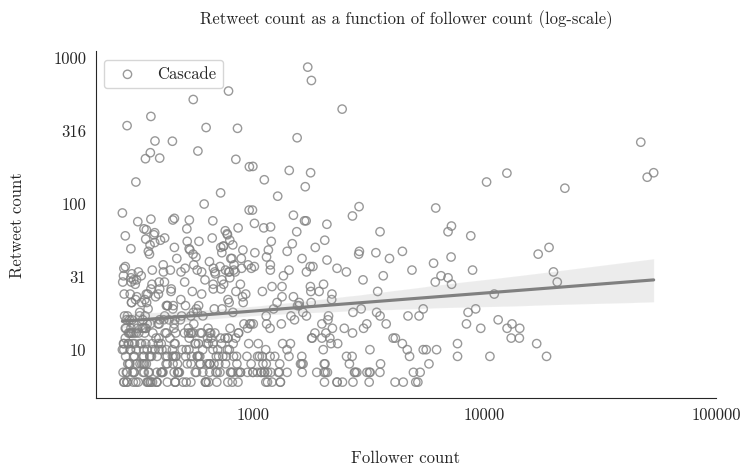

In [30]:
##### PLOT #####
from matplotlib.ticker import FuncFormatter

# Close any previous figure to avoid interference
plt.close()

# Set the figure size to 16:9 aspect ratio
plt.figure(figsize=(16/2, 9/2))

# Scatterplot 
g = sns.regplot(x=np.log10(cascades.n_network_followers), y=np.log10(cascades.n_rts), scatter_kws={'edgecolor': 'gray', 'facecolor': 'None'},color='gray',ci=95)

# Add labels and title to the plot, remove top and right borders
plt.xlabel('Follower count',labelpad=20)
plt.ylabel('Retweet count',labelpad=20)
plt.title('Retweet count as a function of follower count (log-scale)',pad=20)
plt.legend(['Cascade'],loc='upper left')
sns.despine()

# Format axes ticks
g.set_xticks([3, 4, 5])
g.xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(10**x)))
g.yaxis.set_major_formatter(FuncFormatter(lambda y, _: int(10**y)))


# Save the plot as an SVG and PNG file
plt.savefig(fig_path + 'linreg_plot.svg', format='svg', bbox_inches='tight')
plt.savefig(fig_path + 'linreg_plot.png', format='png', bbox_inches='tight', dpi=300)

/Users/ekinderdiyok/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:3381: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = plt.gca()


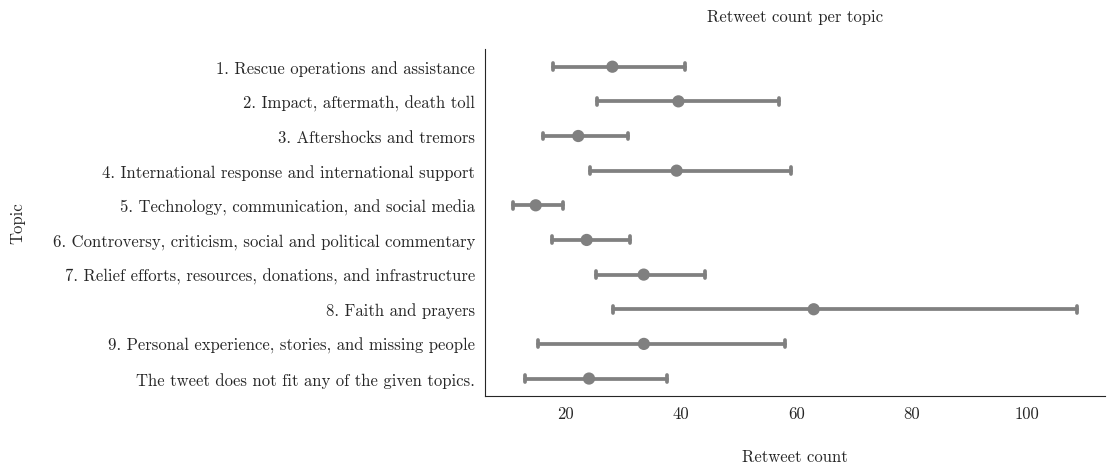

ANOVA Table:
F-statistic: 1.0787471473023063
P-value: 0.3764259530899824
Between-group degrees of freedom: 9
Within-group degrees of freedom: 595


In [36]:
##### RETWEET COUNT PER TOPIC #####
plt.close()
plt.figure(figsize=(16/2, 9/2))
sns.pointplot(y='topic', x='n_rts', data=cascades, errorbar = 'std', capsize=0.2, join=False, dodge=True,color='gray')
plt.title('Retweet count per topic',pad=20)
plt.xlabel('Retweet count',labelpad=20)
plt.ylabel('Topic',labelpad=20)
sns.despine()
# Save the plot as an SVG file
#plt.savefig('/Users/ekinderdiyok/Documents/Thesis/Figures/topic_comp_n_rt_plot.svg', format='svg', bbox_inches='tight')
plt.show()

# Calculate degrees of freedom
num_groups = len(cascades.topic.unique())
total_observations = len(cascades)

df_between = num_groups - 1
df_within = total_observations - num_groups

# ANOVA analysis
anova_result = f_oneway(*[cascades['n_rts'][cascades['topic'] == topic] for topic in cascades['topic'].unique()])

# Print ANOVA table
print("ANOVA Table:")
print("F-statistic:", anova_result.statistic)
print("P-value:", anova_result.pvalue)
print("Between-group degrees of freedom:", df_between)
print("Within-group degrees of freedom:", df_within)

/Users/ekinderdiyok/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:3381: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = plt.gca()


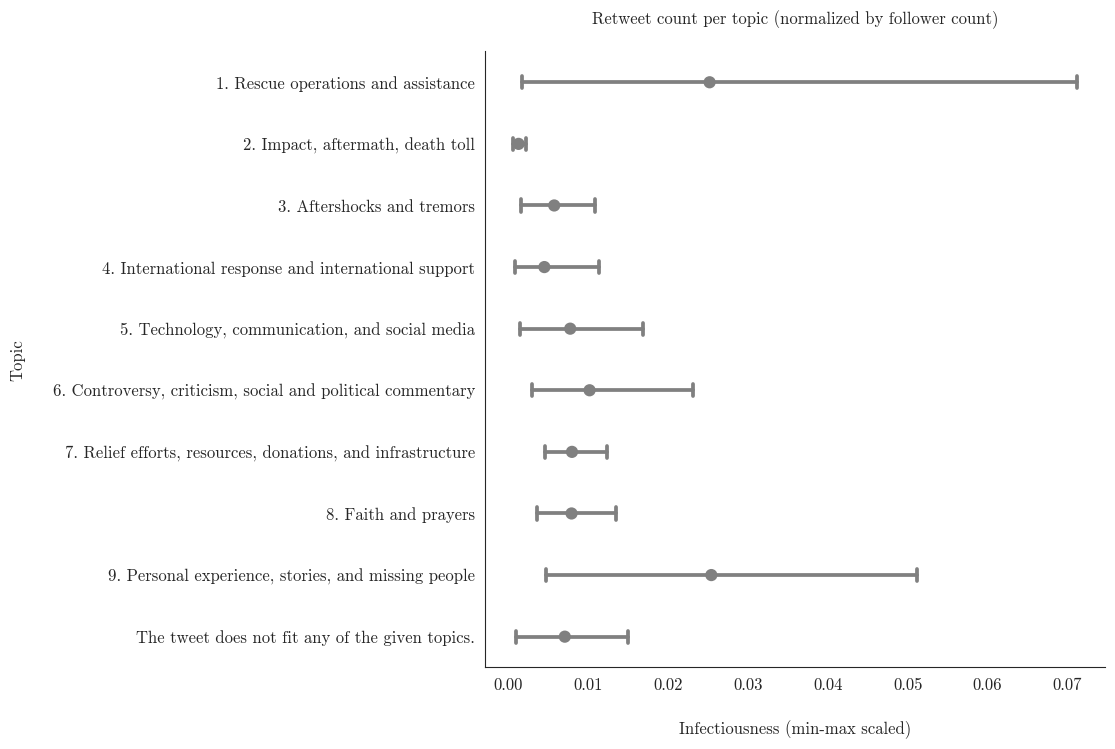

ANOVA Table:
F-statistic: 1.6078428225843107
P-value: 0.10939577473845076
Between-group degrees of freedom: 9
Within-group degrees of freedom: 595


In [37]:
##### RETWEET COUNT PER TOPIC (NORMALIZED) #####

# ANOVA analysis
anova_result = f_oneway(*[cascades['n_rts_norm'][cascades['topic'] == topic] for topic in cascades['topic'].unique()])

# Create a point plot
plt.close()
plt.figure(figsize=(16/2,16/2))
sns.pointplot(y='topic', x='n_rts_norm', data=cascades, errorbar = 'std', capsize=0.2, join=False, dodge=True,color='gray')
plt.title('Retweet count per topic (normalized by follower count)',pad=20)
plt.xlabel('Infectiousness (min-max scaled)',labelpad=20)
plt.ylabel('Topic',labelpad=20)
sns.despine()
plt.show()

# Save the plot as an SVG and PNG file
#plt.savefig('/Users/ekinderdiyok/Documents/Thesis/Figures/topic_n_rt_norm_plot.svg', format='svg', bbox_inches='tight')
#plt.savefig('/Users/ekinderdiyok/Documents/Thesis/Figures/topic_n_rt_norm_plot.png', format='png',bbox_inches='tight', dpi = 300)

# Calculate degrees of freedom
num_groups = len(cascades.topic.unique())
total_observations = len(cascades)

df_between = num_groups - 1
df_within = total_observations - num_groups

# Print ANOVA table
print("ANOVA Table:")
print("F-statistic:", anova_result.statistic)
print("P-value:", anova_result.pvalue)
print("Between-group degrees of freedom:", df_between)
print("Within-group degrees of freedom:", df_within)

### Mean-field models <a class="anchor" id="mean-field-models"></a>

In [38]:
def simulate_base_SI(beta, tweet_id, n_iter):
    """
    Simulates the spread of information in a social network using the mean-field Susceptible-Infectious (SI) model.

    Parameters:
    - beta (float): Transmission rate parameter, representing the probability of an susceptible individual
                   becoming infected when exposed to an infectious individual.
    - tweet_id (int): Identifier for the tweet in the social network cascade.
    - n_iter (int): Number of iterations to simulate the spread of the information.

    Returns:
    - tuple: A tuple containing the simulated number of infections at the end of the simulation (sim) 
             and the observed number of retweets for the given tweet (obs).

    The SI model assumes a simple spread of information in a social network where individuals are either
    susceptible (s) or infectious (i). The simulation progresses in discrete iterations, where at each
    iteration, the number of new infections is calculated based on the transmission rate (beta), the 
    current number of infectious individuals (i), and the number of susceptible individuals (s).

    Parameters:
    - s (float): Initial number of susceptible individuals, obtained from the network information
                associated with the given tweet_id.
    - i (float): Initial number of infectious individuals, set to 1 for the start of the simulation.

    Iteratively, for each iteration in the range of n_iter:
    - Calculate the number of new infections (infected) using the SI model equation: 
      infected = round(beta * i * s)
    - Update the number of susceptible individuals (s) by subtracting the newly infected individuals.
    - Update the number of infectious individuals (i) by adding the newly infected individuals.

    Finally, the function returns a tuple containing the simulated number of infections (sim) at the end
    of the simulation and the observed number of retweets (obs) for the given tweet_id from the cascades data.
    """
    s = cascades.loc[tweet_id].n_network_followers
    i = 1

    for iter in range(n_iter):
        # Calculate the number of new infections based on the SI model
        infected = np.round(beta * i * s)
        s = s - infected
        i = i + infected

    # Final simulation result and observed number of retweets for the given tweet
    sim = i
    obs = cascades.loc[tweet_id].n_rts
    
    return sim, obs

In [39]:
def fit_base_SI(data, n_iter):
    """
    Fits the mean-field Susceptible-Infectious (SI) model to observed data using a minimization approach.

    Parameters:
    - data (pandas.DataFrame): DataFrame containing observed data for multiple tweets in a social network.
                               Each row corresponds to a tweet, and columns include relevant information
                               such as tweet identifiers, observed retweets, and network information.
    - n_iter (int): Number of iterations to simulate the spread of information in the SI model during the fitting process.

    Returns:
    - scipy.optimize.OptimizeResult: Result of the minimization process, containing information about the optimal
                                     transmission rate (beta) that minimizes the difference between simulated and
                                     observed data.

    The function uses a minimization approach to find the optimal transmission rate (beta) for the Basic Susceptible-
    Infectious (SI) model. It defines a loss function based on the Mean Absolute Error (MAE) between simulated and
    observed data for each tweet in the provided DataFrame.

    Parameters:
    - loss_function (function): Inner function that calculates the Mean Absolute Error (MAE) between simulated and
                                observed data for a given transmission rate (beta). It iterates over all tweet_ids
                                in the provided data and accumulates the absolute differences.
    - beta (float): Transmission rate parameter, representing the probability of a susceptible individual becoming
                   infected when exposed to an infectious individual.
    - tweet_ids (numpy.ndarray): Array containing unique identifiers for each tweet in the provided data.
    - sim (float): Simulated number of infections using the SI model for a specific tweet and transmission rate.
    - obs (float): Observed number of retweets for the corresponding tweet from the provided data.

    The `minimize_scalar` function from the scipy library is then used to find the optimal transmission rate that
    minimizes the total Mean Absolute Error (MAE) across all tweets. The result of the minimization process is
    returned as a scipy.optimize.OptimizeResult object.
    """
    def loss_function(beta):
        # Calculate the Mean Absolute Error (MAE) between simulated and observed data
        loss = 0
        tweet_ids = data.index.values
        for tweet_id in tweet_ids:
            sim, obs = simulate_base_SI(beta, tweet_id, n_iter)
            loss += abs(sim - obs)
        return loss

    # Use scalar minimization to find the optimal transmission rate (beta)
    result = minimize_scalar(loss_function, bounds=(0, 1))
    return result

In [40]:
##### SIMULATE #####
beta = 0.0003
tweet_id = pick_random_tweet_id(cascades)
n_iter = 2
sim, obs = simulate_base_SI(beta, tweet_id, n_iter = n_iter)
print(f'sim: {sim}')
print(f'obs: {obs}')

Randomly chosen tweet_id is: '591904771222601728'
sim: 1.0
obs: 28


Estimated beta value is: 3.301066822117917e-05
Model mean absolute deviation is: 32.47107438016529
Pearson's correlation coefficient: 0.1540268084227332
P-value: 0.000142698713937663


/var/folders/j6/6k9fmtb55kj1jy3rcgmt4c4h0000gn/T/ipykernel_1229/4271480173.py:60: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.scatter(obss, sims, marker='o', facecolors='None', edgecolors='gray', label = 'Cascade')


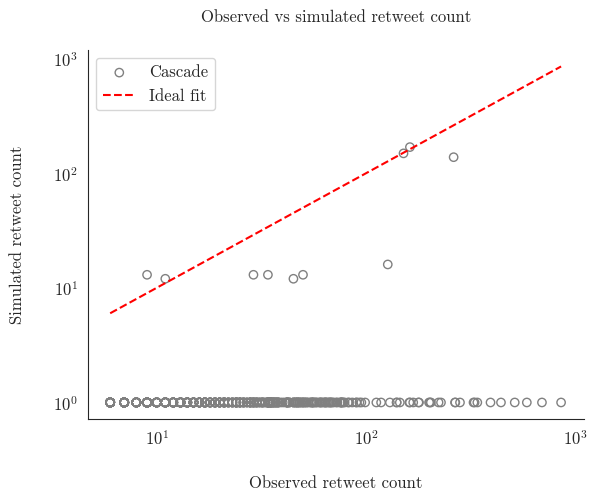

In [47]:
##### FIT, EVALUATE, ESTIMATE (AGGREGATE) #####
result = fit_base_SI(cascades, n_iter = 5)
est_beta = result.x
print(f'Estimated beta value is: {est_beta}')

mse, corr_coef, _, _ = eval_model(simulate_base_SI, est_beta, cascades, n_iter = 5)

In [48]:
##### FIT, EVALUATE, ESTIMATE (GROUPWISE) #####
betas_base_SI = {}
for topic, group in groups.items():
    result = fit_base_SI(group, n_iter=1)
    betas_base_SI[topic] = result.x
betas_base_SI

{'1. Rescue operations and assistance': 0.0019948429533141257,
 '2. Impact, aftermath, death toll': 0.005472924947669958,
 '3. Aftershocks and tremors': 0.0017036612482908854,
 '4. International response and international support': 0.011374489690091772,
 '5. Technology, communication, and social media': 0.01040736755496245,
 '6. Controversy, criticism, social and political commentary': 0.00461215734396671,
 '7. Relief efforts, resources, donations, and infrastructure': 0.0032041176348754294,
 '8. Faith and prayers': 0.004745983709785708,
 '9. Personal experience, stories, and missing people': 0.005500974525024011,
 'The tweet does not fit any of the given topics.': 0.007049282988078733}

In [51]:
###### Fit base SI model (bootstrapped) ######
bs_betas_base_SI = []
bs_samples = create_bootstrap_samples(cascades, 20, len(cascades), 42)
for bs_sample in bs_samples:   
    
    # Fit base SI model (groupwise)
    betas_base_SI = {}
    #groups = split_dataframe_by_category(bs_sample, 'topic')
    for topic, group in groups.items():
        result = fit_base_SI(group, n_iter=1)
        betas_base_SI[topic] = result.x
    
    bs_betas_base_SI.append(betas_base_SI)
    
# Calculate bootstrapped summary statistics (mean and SD)
import statistics

# Create a dictionary to store values for each key
base_SI_key_values = {}

# Iterate through each dictionary in the list
for bs_beta_base_SI in bs_betas_base_SI:
    for key, value in bs_beta_base_SI.items():
        # If the key is not in key_values, create a list for it
        if key not in base_SI_key_values:
            base_SI_key_values[key] = []
        # Append the value to the list for the corresponding key
        base_SI_key_values[key].append(value)
    
base_SI_key_values = pd.DataFrame(base_SI_key_values)
base_SI_key_values = pd.melt(base_SI_key_values, var_name='Topic', value_name='Score')

n_rows that are duplicates: 232
20 bootstrap samples were created


/Users/ekinderdiyok/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:3381: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = plt.gca()


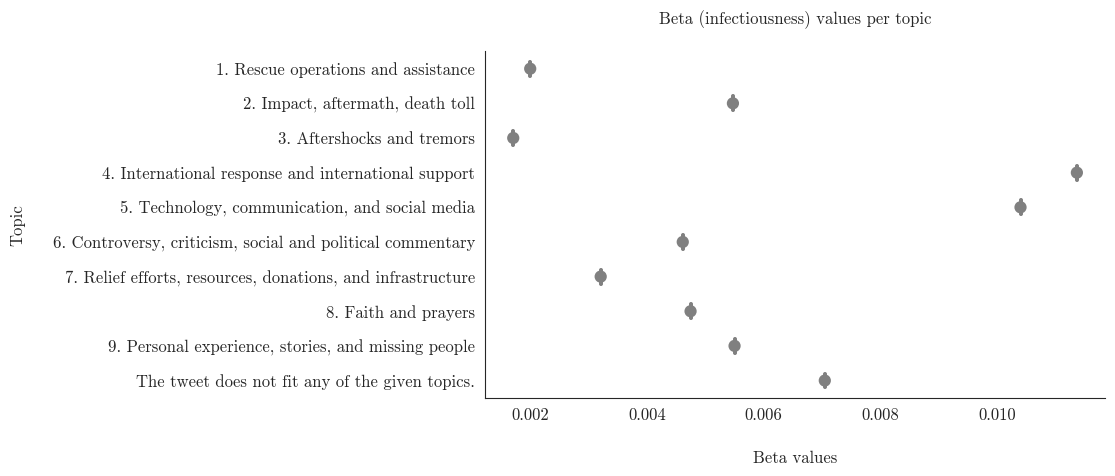

In [52]:
##### PLOT BETAS PER TOPIC #####
plt.close()
plt.figure(figsize=(16/2, 9/2))
sns.pointplot(data = base_SI_key_values, 
              y = 'Topic',
              x = 'Score',
              color=".5",
              capsize=.4,
              errorbar = 'sd',
              join = False)

plt.title('Beta (infectiousness) values per topic',pad =20)
plt.xlabel('Beta values',labelpad=20)
plt.ylabel('Topic',labelpad=20)
sns.despine()

# Save the plot as an SVG file
#plt.savefig('/Users/ekinderdiyok/Documents/Thesis/Figures/topic_comp_base_SI_plot.svg', format='svg', bbox_inches='tight')
plt.show()

### SI Model <a class="anchor" id="si-model"></a>

In [53]:
def simulate_SI(G, beta, tweet_id, n_iter):
    """
    Simulates the spread of information in a social network using the Susceptible-Infectious (SI) model.

    Parameters:
    - G (networkx.Graph): The social network graph representing interactions between users.
    - beta (float): Transmission rate parameter, representing the probability of a susceptible individual
                   becoming infected when exposed to an infectious individual.
    - tweet_id (int): Identifier for the tweet in the social network cascade.
    - n_iter (int): Number of iterations to simulate the spread of the information.

    Returns:
    - tuple: A tuple containing the simulated number of infections at the end of the simulation (sim)
             and the observed number of retweets for the given tweet (obs).

    The SI model simulates the spread of information in a social network where individuals are either susceptible (S) or
    infectious (I). The simulation is performed using the NDlib library for Python. The function creates an instance
    of the SI model, configures it with the provided social network graph, sets the source node (user who tweeted the
    contagion), and runs the simulation for a specified number of iterations.

    Parameters:
    - model (ep.SIModel): Instance of the SI model representing the spread of information.
    - source_node (list): List containing the source node, which is the user who tweeted the contagion.
    - cfg (mc.Configuration): Configuration object specifying model parameters and initial infected nodes.
    - iterations (list): List of simulation iterations containing information about the status of nodes at each iteration.
                        Each iteration includes the count of susceptible and infected nodes.
    - sim (int): Simulated number of infections at the end of the simulation obtained from the final iteration.
    - obs (int): Observed number of retweets for the given tweet obtained from the 'cascades' DataFrame.

    The function returns a tuple containing the simulated number of infections (sim) at the end of the simulation and the
    observed number of retweets (obs) for the given tweet_id from the 'cascades' DataFrame.
    """
    # Create an SI model instance using the provided graph
    model = ep.SIModel(G)

    # Specify the source node as the user who tweeted the contagion
    source_node = [cascades.loc[tweet_id, 'user_id']]

    # Configure the SI model with the given beta value
    cfg = mc.Configuration()
    cfg.add_model_parameter('beta', beta)

    # Set the initial configuration of infected nodes
    cfg.add_model_initial_configuration("Infected", source_node)
    model.set_initial_status(cfg)

    # Run the simulation for the specified number of iterations
    iterations = model.iteration_bunch(n_iter)

    # Extract the simulated number of retweets from the iterations
    sim = iterations[-1]['node_count'][1]
    # Retrieve the observed number of retweets from the 'cascades' DataFrame
    obs = cascades.loc[tweet_id, 'n_rts']

    return sim, obs

In [54]:
def fit_SI(data, n_iter):
    """
    Fits the Susceptible-Infectious (SI) model to observed data using a minimization approach.

    Parameters:
    - data (pandas.DataFrame): DataFrame containing observed data for multiple tweets in a social network.
                               Each row corresponds to a tweet, and columns include relevant information
                               such as tweet identifiers, observed retweets, and network information.
    - n_iter (int): Number of iterations to simulate the spread of information in the SI model during the fitting process.

    Returns:
    - float: Optimal transmission rate (beta) that minimizes the Mean Absolute Error (MAE) between simulated and
             observed data.

    The function uses a minimization approach to find the optimal transmission rate (beta) for the Susceptible-
    Infectious (SI) model. It defines a loss function based on the Mean Absolute Error (MAE) between simulated and
    observed data for each tweet in the provided DataFrame.

    Parameters:
    - loss_function (function): Inner function that calculates the Mean Absolute Error (MAE) between simulated and
                                observed data for a given transmission rate (beta). It iterates over all tweet_ids
                                in the provided data and accumulates the absolute differences.
    - beta (float): Transmission rate parameter, representing the probability of a susceptible individual becoming
                   infected when exposed to an infectious individual.
    - tweet_ids (numpy.ndarray): Array containing unique identifiers for each tweet in the provided data.
    - G (networkx.Graph): Social network graph representing interactions between users in the cascade.
    - sim (int): Simulated number of infections using the SI model for a specific tweet and transmission rate.
    - obs (int): Observed number of retweets for the corresponding tweet from the provided data.

    The `minimize_scalar` function from the scipy library is then used with the bounded optimization method to find
    the optimal transmission rate that minimizes the total Mean Absolute Error (MAE) across all tweets. The result
    is the optimal beta value.
    """
    
    def loss_function(beta):
        loss = 0
        tweet_ids = data.index.values
        for tweet_id in tweet_ids:
            G = create_G(data, tweet_id)
            sim, obs =  simulate_SI(G, beta, tweet_id, n_iter)
            loss += abs(obs - sim)
        return loss

    # Use a simple optimization method to find the beta that minimizes the MSE
    result = minimize_scalar(loss_function, bounds = (0, 1), method = 'bounded')
    return result.x

In [55]:
tweet_id = pick_random_tweet_id(cascades)
G = create_G(cascades, tweet_id)
inspect_G(G)

Randomly chosen tweet_id is: '592195338980696064'
The number of nodes in graph G are 1585
The number of edges in graph G are 1761
The number of retweets is 20
Out-degree of the original poster: 509
In-degree of the original poster: 1
Number of network followers of the original poster: 508


In [61]:
##### SIMULATE #####

tweet_id = pick_random_tweet_id(cascades)
G = create_G(cascades, tweet_id)
#G = create_tweet_cascade_graph(tweet_id)
n_iter = 5 # iter_0 is the initial state with zero infected, iter_1 is only source node infected, hence n_iter makes sense 2 onwards.
beta = 0.0011
sim, obs = simulate_SI(G, beta, tweet_id, n_iter)
print(f'simulated number of retweets: {sim}')
print(f'observed number of retweets: {obs}')

Randomly chosen tweet_id is: '591902876315717632'
simulated number of retweets: 6
observed number of retweets: 64


In [62]:
# Find the best fitting beta parameter
beta_SI = fit_SI(cascades, n_iter = 5)
print(f'Beta estimate of the SI model is: {beta_SI}') # 0.0011351624193084292 or 0.0010706769908942336

Beta estimate of the SI model is: 0.0010706769908942336


Model mean absolute deviation is: 29.560330578512396
Pearson's correlation coefficient: 0.13385286163942256
P-value: 0.0009654736820133697


/var/folders/j6/6k9fmtb55kj1jy3rcgmt4c4h0000gn/T/ipykernel_1229/4271480173.py:60: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.scatter(obss, sims, marker='o', facecolors='None', edgecolors='gray', label = 'Cascade')


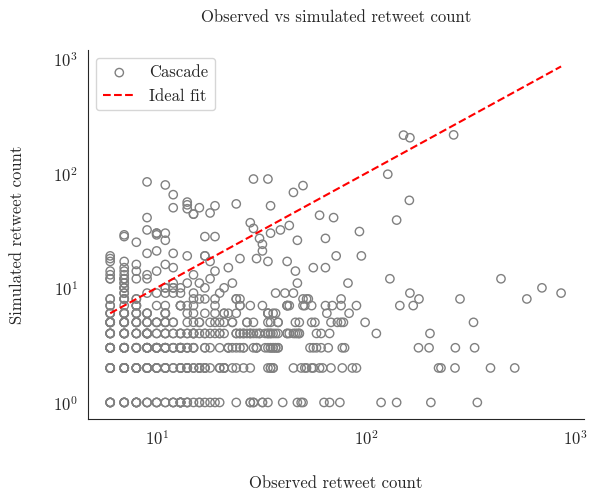

In [64]:
mad, r, _, _ = eval_model(simulate_SI, 0.00107, cascades, n_iter = 5)

In [ ]:
##### FIT, EVALUATE, ESTIMATE (GROUPWISE) #####
betas_SI = {}
for topic, group in groups.items():
    beta = fit_SI(group, n_iter = 3)
    betas_SI[topic] = (beta, len(group))
betas_SI

In [ ]:
##### PLOT BETAS PER TOPICS #####
plt.figure(figsize=(16, 9))

# Get the current Axes instance
ax = plt.gca()

# Set the font size of the x-axis ticks
ax.tick_params(axis='x', labelsize=16)  

# Set the font size of the y-axis ticks
ax.tick_params(axis='y', labelsize=16)  


labels = list(betas_SI.keys())
labels.reverse()
values = [t[0] for t in betas_SI.values()]
values.reverse()
# Creating the point plot
plt.scatter(values, labels, color='blue', marker='D')

# Adding labels and title
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Point Plot from Dictionary')

# Display the plot
plt.show()

### IC Model <a class="anchor" id="ic-model"></a>

In [65]:
def simulate_IC(G, threshold, tweet_id, n_iter):
    """
    Simulates the spread of information in a social network using the Independent Cascades (IC) model.

    Parameters:
    - G (networkx.Graph): The social network graph representing interactions between users.
    - threshold (float): Activation threshold parameter for the Independent Cascades model,
                        representing the probability of an edge transmitting the information.
    - tweet_id (str): Identifier for the tweet in the social network cascade.
    - n_iter (int): Number of iterations to simulate the spread of the information.

    Returns:
    - tuple: A tuple containing the simulated number of infections at the end of the simulation (sim)
             and the observed number of retweets for the given tweet (obs).

    The Independent Cascades (IC) model simulates the spread of information in a social network, where nodes are either
    infected or not infected. The simulation is performed using the NDlib library for Python. The function creates
    an instance of the Independent Cascades model, configures it with the provided social network graph, sets the
    source node (user who tweeted the contagion), and runs the simulation for a specified number of iterations.

    Parameters:
    - model (ep.IndependentCascadesModel): Instance of the NDlib Independent Cascades model representing
                                           the spread of information.
    - source_node (list): List containing the source node, which is the user who tweeted the contagion.
    - cfg (mc.Configuration): Configuration object specifying model parameters and initial infected nodes.
    - iterations (list): List of simulation iterations containing information about the status of nodes at each iteration.
                        Each iteration includes the count of infected and not infected nodes.
    - sim (int): Simulated number of infections at the end of the simulation obtained from the final iteration.
    - obs (int): Observed number of retweets for the given tweet obtained from the 'cascades' DataFrame.

    The function returns a tuple containing the simulated number of infections (sim) at the end of the simulation and the
    observed number of retweets (obs) for the given tweet_id from the 'cascades' DataFrame.
    """
    # Model selection
    model = ep.IndependentCascadesModel(G)

    # Infer source node from tweet_id by looking up the cascades df. Put it in a list
    source_node = [cascades.loc[tweet_id,'user_id']]
    
    # Model Configuration
    cfg = mc.Configuration()
    cfg.add_model_initial_configuration("Infected", source_node)

    # Setting the edge parameters
    for e in G.edges():
        cfg.add_edge_configuration("threshold", e, threshold)
        
    model.set_initial_status(cfg)

    # Simulation execution
    iterations = model.iteration_bunch(n_iter)
    
    # Prepare your outputs
    sim = iterations[-1]['node_count'][1] + iterations[-1]['node_count'][2]
    obs = cascades.loc[tweet_id, 'n_rts']
    
    return sim, obs

In [79]:
def fit_IC(data, n_iter):
    """
    Fits the Independent Cascades (IC) model to observed data using a minimization approach.

    Parameters:
    - data (pandas.DataFrame): DataFrame containing observed data for multiple tweets in a social network.
                               Each row corresponds to a tweet, and columns include relevant information
                               such as tweet identifiers, observed retweets, and network information.
    - n_iter (int): Number of iterations to simulate the spread of information in the IC model during the fitting process.

    Returns:
    - float: Optimal activation threshold that minimizes the Mean Absolute Deviation (MAD) between simulated and
             observed data.

    The function uses a minimization approach to find the optimal activation threshold for the Independent Cascades (IC)
    model. It defines a loss function based on the Mean Absolute Deviation (MAD) between simulated and observed data for
    each tweet in the provided DataFrame.

    Parameters:
    - loss_function (function): Inner function that calculates the Mean Absolute Deviation (MAD) between simulated and
                                observed data for a given activation threshold. It iterates over all tweet_ids in the
                                provided data and accumulates the absolute differences.
    - threshold (float): Activation threshold parameter for the Independent Cascades model, representing the probability
                        of an edge transmitting the information.
    - tweet_ids (numpy.ndarray): Array containing unique identifiers for each tweet in the provided data.
    - G (networkx.Graph): Social network graph representing interactions between users in the cascade.
    - sim (int): Simulated number of infections using the IC model for a specific tweet and activation threshold.
    - obs (int): Observed number of retweets for the corresponding tweet from the provided data.

    The `minimize_scalar` function from the scipy library is then used with the bounded optimization method to find
    the optimal activation threshold that minimizes the total Mean Absolute Deviation (MAD) across all tweets. The result
    is the optimal threshold value.
    """
    def loss_function(threshold):
        # Calculate the Mean Absolute Deviation (MAD) between simulated and observed data
        loss = 0
        tweet_ids = data.index.values
        for tweet_id in tweet_ids:
            G = create_G(cascades, tweet_id)
            sim, obs = simulate_IC(G, threshold, tweet_id, n_iter)
            loss += abs(sim - obs)
        mad = loss / len(tweet_ids)  # Calculate MAD here
        return loss, mad

    # Use scalar minimization to find the optimal activation threshold
    result = minimize_scalar(loss_function, method='bounded', bounds=(0.0001, 0.1))
    return result.x, result.fun[1]

In [72]:
# Set arguments
threshold = 0.005
tweet_id = pick_random_tweet_id(cascades)
G = create_G(cascades, tweet_id)

# Run simulation
sim, obs =  simulate_IC(G, threshold, tweet_id, n_iter=5)

# Print
print(f'Simulated number of retweets: {sim}')
print(f'Observed number of retweets: {obs}')

Randomly chosen tweet_id is: '592298664938221568'
Simulated number of retweets: 2
Observed number of retweets: 10


In [76]:
##### Estimate beta parameter(AGGREGATE) #####
threshold_IC = fit_IC(cascades, n_iter = 5) # 0.00325696610396279
print(f'Threshold estimate of the IC model is: {threshold_IC}')

Threshold estimate of the IC model is: 0.00325696610396279


Model mean absolute deviation is: 29.738842975206612
Pearson's correlation coefficient: 0.12777072063265835
P-value: 0.0016373993081153229


/var/folders/j6/6k9fmtb55kj1jy3rcgmt4c4h0000gn/T/ipykernel_1229/3413228094.py:60: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.scatter(obss, sims, marker='o', facecolors='None', edgecolors='gray', label = 'Cascade')


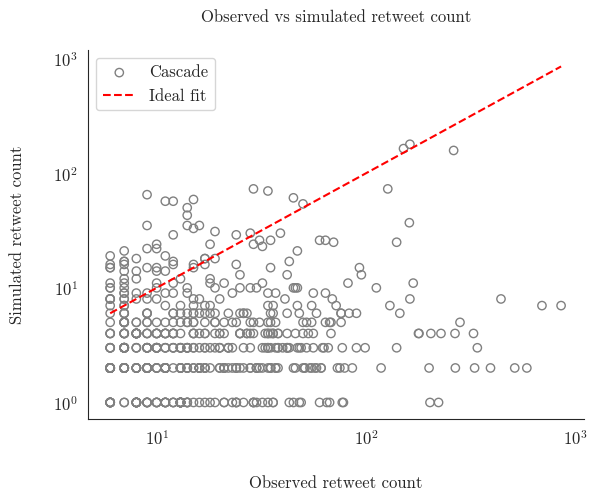

In [78]:
mse, r2, _, _ = eval_model(simulate_IC, threshold_IC, cascades, n_iter = 5)

In [ ]:
##### FIT, EVALUATE, ESTIMATE (GROUPWISE) #####
thresholds_IC = {}
for topic, group in groups.items():
    threshold = fit_IC(group, n_iter = 5)
    thresholds_IC[topic] = (threshold, len(group))
thresholds_IC

In [ ]:
# Plot IC model beta values

plt.figure(figsize=(16/2, 9/2))

# Get the current Axes instance
ax = plt.gca()

# Set the font size of the x-axis ticks
ax.tick_params(axis='x', labelsize=16)  

# Set the font size of the y-axis ticks
ax.tick_params(axis='y', labelsize=16)  
labels = list(thresholds_IC.keys())
labels.reverse()
values = [t[0] for t in thresholds_IC.values()]
sizes = [t[1] for t in thresholds_IC.values()]
values.reverse()
# Creating the point plot
plt.scatter(values, labels, color='gray', marker='o', s = sizes)

# Adding labels and title
plt.xlabel('X-axis Label',labelpad=20)
plt.ylabel('Y-axis Label')
plt.title('Point Plot from Dictionary')

# Annotating each marker with integers from 'sizes'
for i, txt in enumerate(sizes):
    plt.annotate(txt, (values[i], labels[i]), fontsize=12, ha='left', va='center')

# Display the plot
plt.show()

In [ ]:
sem_cat_groups = split_dataframe_by_category(cascades, 'natures')

##### FIT, EVALUATE, ESTIMATE (GROUPWISE) #####
thresholds_IC = {}
for sem_cat, group in sem_cat_groups.items():
    threshold = fit_IC(group, n_iter = 5)
    thresholds_IC[sem_cat] = (threshold, len(group))
thresholds_IC

In [ ]:
{0: (0.004830439502094972, 396),
 1: (0.0036913726414133214, 199),
 2: (0.009305472654999364, 10)}

### Decaying IC model <a class="anchor" id="decaying-ic-model"></a>

In [25]:
def exponential_decay(A, k, t):
    """
    Calculates the value of an exponentially decaying function at a given time.

    Parameters:
    - A (float): The initial amplitude or value of the function at time t=0.
    - k (float): The decay constant, determining the rate of decay.
    - t (float): Time at which to evaluate the function.

    Returns:
    - float: The value of the exponentially decaying function at the specified time.

    The exponential decay function is given by the formula: A * exp(-k * t), where:
    - A is the initial amplitude or value of the function at time t=0.
    - k is the decay constant, determining the rate of decay.
    - t is the time at which to evaluate the function.

    The function uses the math.exp() function from the math module to calculate the exponential function.

    Example:
    >>> exponential_decay(10, 0.1, 2)
    Output: 6.737947005
    """
    return A * math.exp(-k * t)

In [26]:
def sim_decaying_IC(G, threshold, tweet_id, n_iter, k):
    """
    Simulates the spread of information in a social network using the Independent Cascades (IC) model with a decaying threshold.

    Parameters:
    - G (networkx.Graph): The social network graph representing interactions between users.
    - threshold (float): Initial activation threshold parameter for the Independent Cascades model,
                        representing the probability of an edge transmitting the information at time t=0.
    - tweet_id (str): Identifier for the tweet in the social network cascade.
    - n_iter (int): Number of iterations to simulate the spread of information in the IC model with decaying threshold.
    - k (float): Decay constant, determining the rate at which the threshold decays.

    Returns:
    - tuple: A tuple containing the simulated number of infections at the end of the simulation (sim)
             and the observed number of retweets for the given tweet (obs).

    The function simulates the spread of information in a social network using the Independent Cascades (IC) model,
    where nodes are either infected or not infected. The activation threshold for edges decays exponentially over
    iterations with the specified decay constant (k).

    Parameters:
    - model (ep.IndependentCascadesModel): Instance of the NDlib Independent Cascades model representing
                                           the spread of information.
    - source_node (list): List containing the source node, which is the user who tweeted the contagion.
    - cfg (mc.Configuration): Configuration object specifying model parameters and initial infected nodes.
    - iterations (list): List of simulation iterations containing information about the status of nodes at each iteration.
                        Each iteration includes the count of infected and not infected nodes.
    - threshold (float): Activation threshold parameter for the Independent Cascades model at each iteration,
                        decaying exponentially with time.
    - sim (int): Simulated number of infections at the end of the simulation obtained from the final iteration.
    - obs (int): Observed number of retweets for the given tweet obtained from the 'cascades' DataFrame.

    The function returns a tuple containing the simulated number of infections (sim) at the end of the simulation and the
    observed number of retweets (obs) for the given tweet_id from the 'cascades' DataFrame.
    """
    # Model selection
    model = ep.IndependentCascadesModel(G)

    # Infer source node from tweet_id by looking up the cascades df. Put it in a list
    source_node = [cascades.loc[tweet_id, 'user_id']]

    # Model Configuration
    cfg = mc.Configuration()

    # Set the initial infected node
    cfg.add_model_initial_configuration("Infected", source_node)

    # Set initial status
    model.set_initial_status(cfg)

    # Initialize iterations to be able to append to it later on
    iterations = []

    for i in range(n_iter - 1):
        # Update threshold for all edges in cfg and update the model
        for e in G.edges():
            cfg.add_edge_configuration("threshold", e, threshold)
        model.set_initial_status(cfg)

        # Execute the model
        iterations.append(model.iteration_bunch(1))

        # Decay threshold
        threshold = exponential_decay(A=threshold, k=k, t=i)

        # Prepare your func outputs
        sim = iterations[-1][0]['node_count'][1] + iterations[-1][0]['node_count'][2]
        obs = cascades.loc[tweet_id, 'n_rts']

    return sim, obs, iterations

In [27]:
def fit_decay_param(data, n_iter, threshold):
    """
    Fits the Independent Cascades (IC) model with a decaying threshold to observed data using a minimization approach.

    Parameters:
    - data (pandas.DataFrame): DataFrame containing observed data for multiple tweets in a social network.
                               Each row corresponds to a tweet, and columns include relevant information
                               such as tweet identifiers, observed retweets, and network information.
    - n_iter (int): Number of iterations to simulate the spread of information in the IC model with decaying threshold
                    during the fitting process.
    - threshold (float): Initial activation threshold parameter for the Independent Cascades model at time t=0,
                        representing the probability of an edge transmitting the information.

    Returns:
    - scipy.optimize.OptimizeResult: Result of the minimization process, containing information about the optimal
                                     decay constant (k) that minimizes the Mean Absolute Deviation (MAD) between
                                     simulated and observed data.

    The function uses a minimization approach to find the optimal decay constant (k) for the Independent Cascades (IC)
    model with a decaying threshold. It defines a loss function based on the Mean Absolute Deviation (MAD) between
    simulated and observed data for each tweet in the provided DataFrame.

    Parameters:
    - loss_function (function): Inner function that calculates the Mean Absolute Deviation (MAD) between simulated and
                                observed data for a given decay constant (k). It iterates over all tweet_ids in the
                                provided data and accumulates the absolute differences.
    - k (float): Decay constant parameter, determining the rate at which the threshold decays.
    - tweet_ids (numpy.ndarray): Array containing unique identifiers for each tweet in the provided data.
    - G (networkx.Graph): Social network graph representing interactions between users in the cascade.
    - sim (int): Simulated number of infections using the IC model with a decaying threshold for a specific tweet and decay constant.
    - obs (int): Observed number of retweets for the corresponding tweet from the provided data.

    The `minimize_scalar` function from the scipy library is then used to find the optimal decay constant (k) that
    minimizes the total Mean Absolute Deviation (MAD) across all tweets. The result of the minimization process is
    returned as a scipy.optimize.OptimizeResult object.
    """
    def loss_function(k):
        # Calculate the Mean Absolute Deviation (MAD) between simulated and observed data
        loss = 0
        tweet_ids = data.index.values
        for tweet_id in tweet_ids:
            G = create_G(cascades, tweet_id)
            sim, obs = sim_decaying_IC(G, threshold, tweet_id, n_iter, k)
            loss += abs(sim - obs)
        return loss

    # Use scalar minimization to find the optimal decay constant (k)
    result = minimize_scalar(loss_function)
    return result


In [85]:
##### Fit decay parameter #####
result = fit_decay_param(cascades, n_iter = 5, threshold = 0.00325) # 0.9418582301857517
k = result.x
k

0.9418582301857517

Model mean absolute deviation is: 29.689256198347106
Pearson's correlation coefficient: 0.1327233882723517
P-value: 0.0010667636911970283


/var/folders/j6/6k9fmtb55kj1jy3rcgmt4c4h0000gn/T/ipykernel_1229/3413228094.py:60: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.scatter(obss, sims, marker='o', facecolors='None', edgecolors='gray', label = 'Cascade')


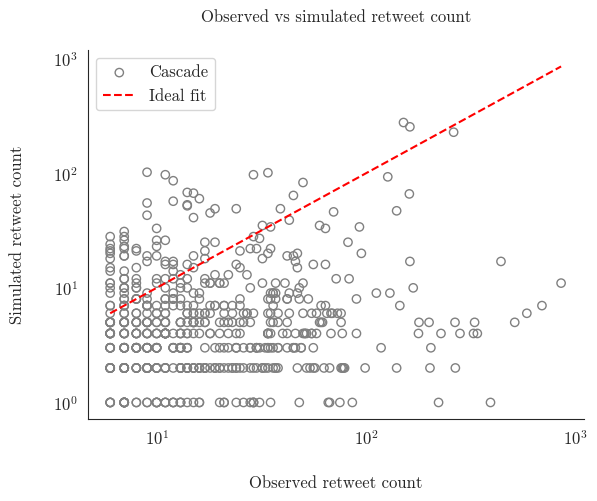

In [87]:
mad, corr_coef, sims, obss = eval_model(sim_decaying_IC, param = 0.00325, data = cascades, n_iter = 5, k = k)

In [220]:
##### SIMULATE DECAYING IC FOR A RANDOMLY CHOSEN CASCADE #####

threshold = 0.003
tweet_id = pick_random_tweet_id(cascades)
G = create_G(cascades, tweet_id)

sim, obs, iterations = sim_decaying_IC(G, threshold, tweet_id, n_iter = 5, k = 0.94)
print(f'simulated number of retweets: {sim}')
print(f'observed number of retweets: {obs}')

Randomly chosen tweet_id is: '591918737676111872'
simulated number of retweets: 5
observed number of retweets: 13


### ECDF vs Decaying IC <a class="anchor" id="ecdf-vs-dec-IC"></a>

In [5]:
def pick_n_tweets(n, seed):
    """
    Selects and returns a list of unique tweet IDs from a collection of tweet cascades.

    Parameters:
    - n (int): The number of tweet IDs to pick.
    - seed (int): Seed for reproducibility, ensures consistent random selections.

    Returns:
    - list: A list containing 'n' unique tweet IDs randomly chosen from the tweet cascades.

    Usage Example:
    --------------
    tweet_ids = pick_n_tweets(n=15, seed=8)

    Description:
    ------------
    This function is designed to randomly select 'n' unique tweet IDs from a predefined collection of tweet cascades.
    The randomization is performed using NumPy's random module, with the provided 'seed' ensuring reproducibility.
    
    The tweet IDs are selected using the internal function 'pick_random_tweet_id' with the collection of cascades as
    an input parameter. The selected tweet IDs are then appended to a list and returned.

    Note:
    -----
    It is assumed that the 'pick_random_tweet_id' function is defined elsewhere and takes the tweet cascades as an
    argument, returning a randomly selected tweet ID from the provided collection.

    Parameters and their Descriptions:
    -----------------------------------
    - n (int): The number of tweet IDs to be randomly selected and returned by the function.
    - seed (int): An integer seed for the random number generator to ensure reproducibility. By providing the same
      seed value, the function will yield the same set of random tweet IDs on subsequent runs.

    Returns:
    --------
    - list: A list containing 'n' unique tweet IDs randomly chosen from the given tweet cascades.

    Example Usage:
    --------------
    tweet_ids = pick_n_tweets(n=15, seed=8)
    # This will generate a list of 15 unique tweet IDs randomly selected from the cascades.

    """
    np.random.seed(seed)
    tweet_ids = []
    for _ in range(n):
        tweet_ids.append(pick_random_tweet_id(cascades))
    return tweet_ids

In [22]:
def create_list_cum_n_rts(tweet_ids, jitter_factor=0.05):
    """
    Generate a list of cumulative retweet counts over iterations for each tweet in the given list of tweet IDs.

    Parameters:
    - tweet_ids (list): A list of tweet IDs for which the cumulative retweet counts are to be calculated.

    Returns:
    - list_cum_n_rts_scaled (list): A list containing scaled cumulative retweet counts for each tweet.
    
    Algorithm:
    1. For each tweet_id in the input list, create a cascade network G using the provided cascades and tweet_id.
    2. Calculate cumulative retweet counts over iterations using the sim_decaying_IC function.
    3. Extract node counts for each iteration and store them in a list.
    4. Apply Min-Max scaling to each sublist of cumulative retweet counts.
    5. Return the list of scaled cumulative retweet counts.

    Note:
    - The scaling is performed using Min-Max scaling from the scikit-learn library.
    - The sim_decaying_IC function and create_G function are assumed to be defined elsewhere in the codebase.

    See Also:
    - sim_decaying_IC: Function for simulating information cascades with decaying influence.
    - create_G: Function for creating a network graph for a given cascade and tweet_id.
    """
    list_cum_n_rts = []

    # Iterate over each tweet_id
    for tweet_id in tweet_ids:
        # Create cascade network G for the current tweet_id
        G = create_G(cascades, tweet_id)
        
        # Simulate information cascades and get cumulative retweet counts over iterations
        sim, obs, iterations = sim_decaying_IC(G, threshold=0.003, tweet_id=tweet_id, n_iter=5, k=0.94)

        # Extract node counts for each iteration and store in a list
        iter_0 = iterations[0][0]['node_count'][1] + iterations[0][0]['node_count'][2]
        iter_1 = iterations[1][0]['node_count'][1] + iterations[1][0]['node_count'][2]
        iter_2 = iterations[2][0]['node_count'][1] + iterations[2][0]['node_count'][2]
        iter_3 = iterations[3][0]['node_count'][1] + iterations[3][0]['node_count'][2]
        list_cum_n_rts.append([iter_0, iter_1, iter_2, iter_3])

    # Initialize the MinMaxScaler
    scaler = MinMaxScaler()

    # Apply the min-max scaling to each sublist
    list_cum_n_rts_scaled = [scaler.fit_transform(np.array(sublist).reshape(-1, 1)).flatten().tolist() for sublist in list_cum_n_rts]
    
    list_cum_n_rts_jittered = [[val + np.random.uniform(-jitter_factor, jitter_factor) for val in sublist] for sublist in list_cum_n_rts_scaled]

    return list_cum_n_rts_jittered

In [23]:
def fit_log_model_iter(data):
    
    # Subset your data, create y variable
    y = data[1:]
    x = [1,2,3]
    
    # Fit the logarithmic model to the data
    params, covariance = curve_fit(logarithmic_function, x, y)
    
    # Extract the estimated parameters
    a, b = params
    
    return params

In [30]:
tweet_ids = cascades.index.values
list_cum_n_rts_scaled = create_list_cum_n_rts(tweet_ids, jitter_factor = 0)

params = [fit_log_model_iter(sublist) for sublist in list_cum_n_rts_scaled]

# Extract the first and second elements from each ndarray and store them in separate lists
a = np.median([arr[0] for arr in params])
b = np.median([arr[1] for arr in params])

print("Median of the first elements:", a)
print("Median of the second elements:", b)

Median of the first elements: 0.2542568520718124
Median of the second elements: 0.6962597845721614


Randomly chosen tweet_id is: '592203614262665217'
Randomly chosen tweet_id is: '592351505132322819'
Randomly chosen tweet_id is: '591905353845100544'
Randomly chosen tweet_id is: '592266019181240322'
Randomly chosen tweet_id is: '592224880122200065'
Randomly chosen tweet_id is: '592351223988248576'
Randomly chosen tweet_id is: '592205017030995969'
Randomly chosen tweet_id is: '592363682295717888'
Randomly chosen tweet_id is: '592146129409703936'
Randomly chosen tweet_id is: '592284493261602817'
Randomly chosen tweet_id is: '592347512297521152'
Randomly chosen tweet_id is: '592228589606572033'
Randomly chosen tweet_id is: '592251544512299008'
Randomly chosen tweet_id is: '592270063555612672'
Randomly chosen tweet_id is: '592603007444852736'


/var/folders/j6/6k9fmtb55kj1jy3rcgmt4c4h0000gn/T/ipykernel_1564/1614142972.py:14: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.scatter(x, y, alpha=0.1, color = 'black',s=10)


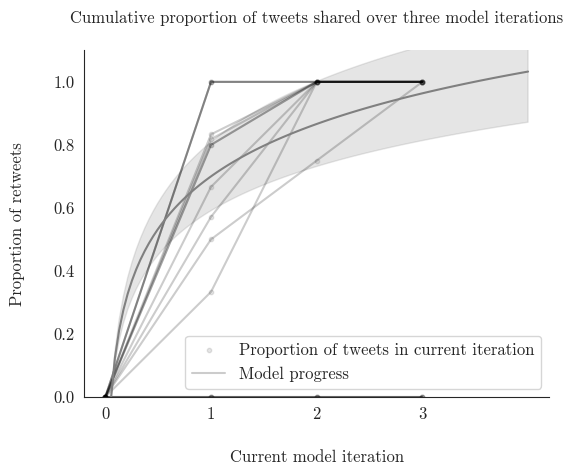

In [32]:
###### Plot model iteration with error band (multiple) ######

# Close, open
plt.close()
plt.figure(figsize=(12/2,9/2))

# Plot
np.random.seed(8)
tweet_ids = pick_n_tweets(n = 15, seed = 8)
for i in range(15):
    list_cum_n_rts_scaled = create_list_cum_n_rts(tweet_ids, jitter_factor = 0.05)
    x = [0,1,2,3]
    y = list_cum_n_rts_scaled[i]
    plt.scatter(x, y, alpha=0.1, color = 'black',s=10)
    plt.plot(x, y, linestyle='-', color='black', label='Connected Line', alpha= 0.2)

# Generate x values for log curve
x_values = np.linspace(0.01, 4, 100)  # Avoid log(0) by starting from a small value

# Calculate y values using the log func params
y_values = 0.24 * np.log(x_values) + 0.7

# Plot fitted log curve
plt.plot(x_values, y_values, '-', label='Fitted Logarithmic Curve',color='gray')
    
# Aesthetics
plt.xlabel('Current model iteration',labelpad=20)
plt.ylabel('Proportion of retweets',labelpad=20)
plt.title('Cumulative proportion of tweets shared over three model iterations',pad=20)
plt.legend(['Proportion of tweets in current iteration', 'Model progress'],loc='lower right')
plt.xticks(x) # Make sure x axis is 1,2,3
sns.despine() # Remove the top and right spines for a cleaner appearance

# Error bars
def calc_mean_error_per_cascade(timestamps):
    """
    Calculates the mean absolute error between predicted and true values for a set of timestamps.

    Parameters:
    - timestamps (numpy.ndarray or list): Array or list containing timestamp values.

    Returns:
    - float: Mean absolute error between predicted and true values.

    The function generates predicted values using a logarithmic function and calculates the mean absolute error
    between the predicted and true values.

    Parameters:
    - timestamps (numpy.ndarray or list): Array or list of timestamp values for which to calculate the mean absolute error.
    - y_true (numpy.ndarray): Array containing true values, generated as a linspace from 0 to 1.
    - y_pred (numpy.ndarray): Predicted values generated using a logarithmic function.
    - mean_abs_err (float): Mean absolute error calculated between y_true and y_pred.

    Example:
    >>> timestamps = [0, 2, 4, 6, 8, 10]
    >>> calc_mean_error_per_cascade(timestamps)
    Output: 0.123
    """
    y_true = np.linspace(0, 1, len(timestamps))[1:]
    y_pred = logarithmic_function(a=0.24, b=0.7, x=y_true)

    mean_abs_err = np.mean(abs(y_pred - y_true))

    return mean_abs_err

def calc_grand_mean_abs_err(list_cum_n_rts_scaled):
    mean_errors = []
    for cum_n_rts_scaled in list_cum_n_rts_scaled:
        mean_error = calc_mean_error_per_cascade(cum_n_rts_scaled)
        mean_errors.append(mean_error)
        grand_mean_abs_err = np.mean(mean_errors)
    return grand_mean_abs_err

grand_mean_abs_err = calc_grand_mean_abs_err(list_cum_n_rts_scaled)
variance_multiplier = grand_mean_abs_err
variance = variance_multiplier * np.abs(y_values)
plt.fill_between(x_values, y_values - variance, y_values + variance, alpha=0.2, label='Error bands',color = 'Gray')

plt.ylim([0,1.1])

# Save
plt.savefig(fig_path + 'model_iter_band.svg', format='svg', bbox_inches='tight')
plt.savefig(fig_path + 'model_iter_band.png', format='png', bbox_inches='tight', dpi=400)

# Show
plt.show()

## Time series analysis  <a class="anchor" id="time-series-analysis"></a>

### ECDF plot <a class="anchor" id="ecdf-plot"></a>

In [446]:
def plot_timestamps_ecdf(timestamps):
    
    """
    Plots the Empirical Cumulative Distribution Function (ECDF) of timestamps.

    Parameters:
    - timestamps (numpy.ndarray or list): Array or list containing timestamp values.

    Returns:
    - None

    The function scales the timestamps, creates an ECDF plot, and visualizes the cumulative proportion of retweets
    over time.

    Parameters:
    - timestamps (numpy.ndarray or list): Array or list of timestamp values to be plotted.

    The function uses the seaborn library to create an ECDF plot with markers for each timestamp. The plot includes
    labels for the x and y-axes, a title, and a legend. The y-axis limits are set to ensure the top marker is not cut-off.
    The top and right spines are removed for a cleaner appearance.

    Example:
    >>> timestamps = [0, 2, 4, 6, 8, 10]
    >>> plot_timestamps_ecdf(timestamps)
    """

    timestamps = scale_timestamps(timestamps)
    
    # Close any previous figure to avoid interference
    plt.close()
    
    # Set the figure size to 16:9 aspect ratio
    plt.figure(figsize=(16/2, 9/2))
  
    # Create an Empirical Cumulative Distribution Function (ECDF) plot
    sns.ecdfplot(timestamps, marker="o", linestyle="-", alpha = 1, markersize = 5, markerfacecolor='None',markeredgecolor='gray', color = (0.5,0.5,0.5))
    
    # Add labels and title to the plot
    plt.xlabel('Hours passed since the original tweet',labelpad=20)
    plt.ylabel('Proportion of retweets',labelpad=20)
    plt.title('Cumulative proportion of tweets shared over time',pad=20)
    plt.legend(['Retweet'],loc='lower right')
    
    # Set y-axis limits to ensure the top marker is not cut-out
    plt.ylim(0, 1.06)
    
    # Remove the top and right spines for a cleaner appearance
    sns.despine()
    
    # Save the plot as an SVG file
    plt.savefig(fig_path + 'ecdf_plot.svg', format='svg', bbox_inches='tight')

    # Display the plot
    plt.show()

In [ ]:
# Pick random tweet_id
tweet_id = pick_random_tweet_id(cascades)

# Access timestamps
timestamps = cascades.loc[tweet_id].timestamps

# Plot it
plot_timestamps_ecdf(timestamps)

### Avrami Equation <a class="anchor" id="avrami-equation"></a>

In [4]:
def avrami_equation(t, k, n):
    """
    Calculate the Avrami equation value at a given time.

    The Avrami equation is a mathematical model used to describe phase transformation
    kinetics in materials, such as crystallization and nucleation. It is expressed
    as:

    A(t) = 1 - exp(-k * t^n)

    where:
    - A(t) is the fraction of transformation at time t.
    - k is the rate constant that depends on the specific process.
    - n is the Avrami exponent that characterizes the reaction mechanism.

    Parameters:
    t (float): Time at which to calculate the transformation fraction.
    k (float): Rate constant of the Avrami equation.
    n (float): Avrami exponent, characterizing the reaction mechanism.

    Returns:
    float: The fraction of transformation at time t according to the Avrami equation.

    Example:
    >>> avrami_equation(2.5, 0.1, 2)
    0.18126924692201818
    """
    return 1 - np.exp(-k * t**n)

In [39]:
def plot_avrami_equation(k, n, t_max=48, num_points=100):
    """
    Plots the Avrami equation for a given set of parameters.

    The Avrami equation is used to model phase transformation kinetics in materials,
    describing how the fraction transformed changes over time during processes like
    crystallization, precipitation, etc.

    Parameters:
    k (float): The rate constant in the Avrami equation.
    n (float): The Avrami exponent in the Avrami equation.
    t_max (float, optional): The maximum time for the plot. Defaults to 10.
    num_points (int, optional): The number of points to generate in the time range.
        Defaults to 100.

    Returns:
    None: This function plots the Avrami equation but does not return any value.

    Example:
    plot_avrami_equation(k=0.1, n=2)

    This will generate a plot of the Avrami equation with the specified k and n values.
    You can adjust the t_max and num_points parameters to control the time range and
    the number of points in the plot.
    """
    t = np.linspace(0, t_max, num_points)
    f = avrami_equation(t, k, n)
    
    plt.close()
    plt.figure(figsize=(16/2, 9/2))
    plt.plot(t, f, label=f'k={k}, n={n}',color='gray')
    plt.xlabel('Time (t)', labelpad = 20)
    plt.ylabel('Proportion of retweets f(t)', labelpad = 20)
    plt.title('Avrami Equation Plot',pad = 20)
    plt.legend(loc = 'lower right')
    sns.despine()
    plt.savefig('/Users/ekinderdiyok/Documents/Thesis/Figures/avrami.svg', bbox_inches='tight')
    plt.savefig('/Users/ekinderdiyok/Documents/Thesis/Figures/avrami.png', dpi = 400,  bbox_inches='tight')
    plt.show()

/var/folders/j6/6k9fmtb55kj1jy3rcgmt4c4h0000gn/T/ipykernel_1552/2910627107.py:31: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.plot(t, f, label=f'k={k}, n={n}',color='gray')


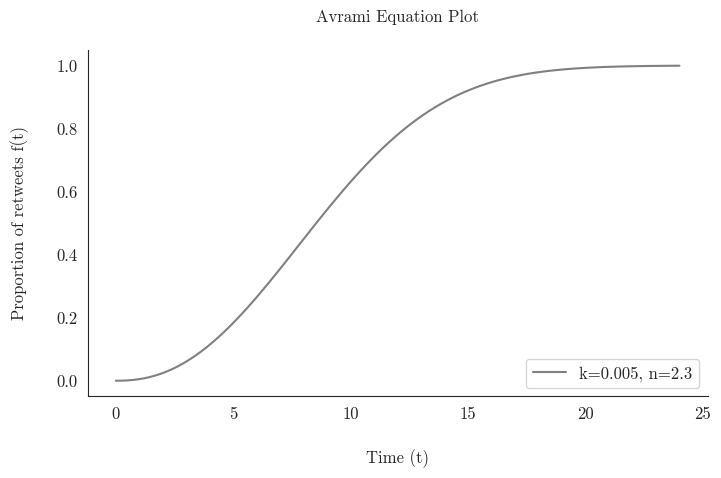

In [40]:
# Simulate the equation with arbitrary values
t, k, n = 24, 0.005, 2.3
avrami_equation(t, k, n)

# Plot simulated equation
plot_avrami_equation(k = k, n = n, t_max = 24)

### Logarithmic fit (single) <a class="anchor" id="logarithmic-fit-single"></a>

In [29]:
def logarithmic_function(x, a, b):
    return a * np.log(x) + b

In [4]:
def fit_log_model(data):
    
    # Subset your data, create y variable
    x = data[1:]
    y = np.linspace(0, 1, len(data))[1:]
    
    # Fit the logarithmic model to the data
    params, covariance = curve_fit(logarithmic_function, x, y)
    
    # Extract the estimated parameters
    a, b = params

    #print(f'a * log(x) + b: parameter a is {a}, b is {b})')
    
    return params

In [249]:
# Fit log function to a randomly selected tweet.
tweet_id = pick_random_tweet_id(cascades)
timestamps = scale_timestamps(cascades.loc[tweet_id].timestamps)
_ = fit_log_model(timestamps)

Randomly chosen tweet_id is: '592399224660066304'


### Logarithmic fit (aggregate) <a class="anchor" id="logarithmic-fit-aggregate"></a>

In [250]:
cascades['log_params'] = cascades.scaled_timestamps.apply(fit_log_model)

a = cascades.log_params.apply(lambda x: x[0]).median() # a = 0.17
b = cascades.log_params.apply(lambda x: x[1]).median() # b = 0.77

print(f'a is: {a}')
print(f'b is: {b}')

a is: 0.1691608246422405
b is: 0.768905966359572


/Users/ekinderdiyok/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [251]:
def calc_mean_error_per_cascade(timestamps):
    """
    Calculates the mean absolute error between predicted and true values for a set of timestamps.

    Parameters:
    - timestamps (numpy.ndarray or list): Array or list containing timestamp values.

    Returns:
    - float: Mean absolute error between predicted and true values.

    The function generates predicted values using a logarithmic function and calculates the mean absolute error
    between the predicted and true values.

    Parameters:
    - timestamps (numpy.ndarray or list): Array or list of timestamp values for which to calculate the mean absolute error.
    - y_true (numpy.ndarray): Array containing true values, generated as a linspace from 0 to 1.
    - y_pred (numpy.ndarray): Predicted values generated using a logarithmic function.
    - mean_abs_err (float): Mean absolute error calculated between y_true and y_pred.

    Example:
    >>> timestamps = [0, 2, 4, 6, 8, 10]
    >>> calc_mean_error_per_cascade(timestamps)
    Output: 0.123
    """
    y_true = np.linspace(0, 1, len(timestamps))[1:]
    y_pred = logarithmic_function(a=0.17, b=0.77, x=y_true)

    mean_abs_err = np.mean(abs(y_pred - y_true))

    return mean_abs_err

Randomly chosen tweet_id is: '592203614262665217'
Randomly chosen tweet_id is: '592351505132322819'
Randomly chosen tweet_id is: '591905353845100544'
Randomly chosen tweet_id is: '592266019181240322'
Randomly chosen tweet_id is: '592224880122200065'
Randomly chosen tweet_id is: '592351223988248576'
Randomly chosen tweet_id is: '592205017030995969'
Randomly chosen tweet_id is: '592363682295717888'
Randomly chosen tweet_id is: '592146129409703936'
Randomly chosen tweet_id is: '592284493261602817'
Randomly chosen tweet_id is: '592347512297521152'
Randomly chosen tweet_id is: '592228589606572033'
Randomly chosen tweet_id is: '592251544512299008'
Randomly chosen tweet_id is: '592270063555612672'
Randomly chosen tweet_id is: '592603007444852736'


/var/folders/j6/6k9fmtb55kj1jy3rcgmt4c4h0000gn/T/ipykernel_16815/1693010636.py:29: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.scatter(x, y, label=f'Tweet ID: {tweet_id}', alpha=0.1, color = 'black',s=10)


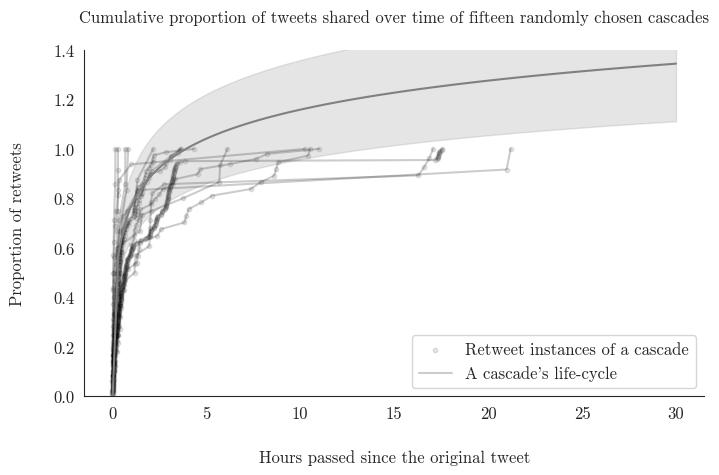

In [265]:
###### Plot logarithmic function (aggregate) ######

def calc_grand_mean_abs_err(data):
    mean_errors = []
    tweet_ids = data.index.values
    for tweet_id in tweet_ids:
        mean_error = calc_mean_error_per_cascade(cascades.loc[tweet_id].timestamps)
        mean_errors.append(mean_error)
        grand_mean_abs_err = np.mean(mean_errors)
    return grand_mean_abs_err

grand_mean_abs_err = calc_grand_mean_abs_err(data = cascades)
grand_mean_abs_err

# Generate x values
x_values = np.linspace(0.01, 30, 100)  # Avoid log(0) by starting from a small value

# Calculate y values using the logarithmic function
y_values = a * np.log(x_values) + b

plt.close()
plt.figure(figsize=(16/2,9/2))
# Generate and plot scatterplots for 4 random tweet IDs
np.random.seed(8)
for _ in range(15):
    tweet_id = pick_random_tweet_id(cascades)
    x = cascades.loc[tweet_id].scaled_timestamps[1:]
    y = np.linspace(0, 1, len(x)+1)[1:]
    plt.scatter(x, y, label=f'Tweet ID: {tweet_id}', alpha=0.1, color = 'black',s=10)
    plt.plot(x, y, linestyle='-', color='black', label='Connected Line', alpha= 0.2)


filtered_indices = y_values <= 1.05
filtered_x_values = x_values[filtered_indices]
filtered_y_values = y_values[filtered_indices]
    
    
plt.plot(x_values, y_values, '-', label='Fitted Logarithmic Curve',color='gray')
plt.xlabel('Hours passed since the original tweet',labelpad=20)
plt.ylabel('Proportion of retweets',labelpad=20)
plt.title('Cumulative proportion of tweets shared over time of fifteen randomly chosen cascades',pad=20)

plt.legend(['Retweet instances of a cascade', 'A cascade\'s life-cycle'],loc='lower right')
plt.ylim([0,1.4])

# Error bands
variance_multiplier = grand_mean_abs_err
variance = variance_multiplier * np.abs(y_values)
plt.fill_between(x_values, y_values - variance, y_values + variance, alpha=0.2, label='Error bands',color = 'Gray')

# Remove the top and right spines for a cleaner appearance
sns.despine()

# Save
plt.savefig(fig_path + 'log_plot.svg', format='svg', bbox_inches='tight')
plt.savefig(fig_path + 'log_plot.png', format='png', bbox_inches='tight', dpi=200)

plt.show()

### Viral vs broadcast time series <a class="anchor" id="viral-vs-broadcast"></a>

In [100]:
# Create viral and broadcast subsets of cascades

# Function to calculate median for a list
calculate_median = lambda x: pd.Series(x).median()

# Apply the function to each cell in the specified column
medians = cascades['scaled_timestamps'].apply(calculate_median)

# Select rows where the median is smaller than 1
viral_cascades = cascades[medians > 1]
broadcast_cascades = cascades[medians <= 1]

# Display the result
broadcast_cascades

,retweeters,timestamps,n_rts,user_id,followers,n_network_followers,link,scaled_timestamps,n_followers,text,topic,natures,length,i_topic,n_rts_norm
tweet_id,,,,,,,,,,,,,,,
591984228121837568,"[2397106153, 2831673248, 2453676953, 520542949...","[1429955271.0, 1429955284.0, 1429955285.0, 142...",162,428333,"[428333, 332885182, 2391585170, 34266989, 6036...",53849,https://twitter.com/anyuser/status/59198422812...,"[0.0, 0.003611111111111111, 0.0038888888888888...",43000.0,#NepalEarthquake -- @CNNImpact now lists way...,"7. Relief efforts, resources, donations, and i...",0,140,7,0.003767
592280118376026113,"[3195732905, 150493886, 2162649559, 391354039,...","[1430026217.0, 1430026268.0, 1430026277.0, 143...",151,742143,"[742143, 3163742796, 2391585170, 1096566492, 3...",50490,https://twitter.com/anyuser/status/59228011837...,"[0.0, 0.014166666666666666, 0.0166666666666666...",17500.0,People are camping outside #NepalEarthquake,"7. Relief efforts, resources, donations, and i...",1,43,7,0.008629
592158743455993856,"[1550821693, 760544600, 1375526088, 42346547, ...","[1429996870.0, 1429996875.0, 1429996914.0, 142...",262,759251,"[759251, 3163742796, 2391585170, 1096566492, 3...",47366,https://twitter.com/anyuser/status/59215874345...,"[0.0, 0.001388888888888889, 0.0122222222222222...",210100.0,Are you searching for someone after the #Nepal...,"9. Personal experience, stories, and missing p...",0,105,9,0.001247
591922467360276480,"[101198777, 2465344748, 2774554965, 456982384,...","[1429941204.0, 1429941218.0, 1429941219.0, 142...",127,18681139,"[18681139, 91962351, 26461628, 972384505, 1132...",22237,https://twitter.com/anyuser/status/59192246736...,"[0.0, 0.0038888888888888888, 0.004166666666666...",4234.0,@priyankachopra Do share this For blood requ...,"7. Relief efforts, resources, donations, and i...",0,105,7,0.029995
592220099156676609,"[3101345671, 1052663983, 18939918, 474868210, ...","[1430012101.0, 1430012146.0, 1430012199.0, 143...",29,134758540,"[134758540, 1132711926, 102717635, 313385516, ...",20612,https://twitter.com/anyuser/status/59222009915...,"[0.0, 0.0125, 0.02722222222222222, 0.039444444...",3263.0,#Makalu 40 climbers from 20 teams are safe in ...,"7. Relief efforts, resources, donations, and i...",0,124,7,0.008888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
592209786940174336,"[1528284492, 2578308889, 173064517, 2649284857...","[1430009325.0, 1430009388.0, 1430009406.0, 143...",11,2455987260,"[2455987260, 346316391, 2372162220, 94853291, ...",274,https://twitter.com/anyuser/status/59220978694...,"[0.0, 0.0175, 0.0225, 0.042222222222222223, 0....",4300000.0,#IAF and #IndianArmy together are conducting o...,4. International response and international su...,0,107,4,0.000003
592168024100110336,"[157542990, 145513817, 3062192240, 33793786, 1...","[1429999211.0, 1429999372.0, 1429999724.0, 142...",7,549679303,"[549679303, 17679507, 2359028480, 2845917181, ...",273,https://twitter.com/anyuser/status/59216802410...,"[0.0, 0.04472222222222222, 0.1425, 0.183888888...",3108.0,Our thoughts and prayers are with #Nepal. #ear...,"7. Relief efforts, resources, donations, and i...",1,53,7,0.002252
591910829194285057,"[2374090597, 437397401, 528039191, 251016927, ...","[1429937745.0, 1429937784.0, 1429937785.0, 142...",29,2375276990,"[2375276990, 142379064, 2375531316, 828068220,...",272,https://twitter.com/anyuser/status/59191082919...,"[0.0, 0.010833333333333334, 0.0111111111111111...",8000000.0,"As much help as they (Nepal) want, we will pro...",4. International response and international su...,0,111,4,0.000004


In [99]:
# Explore broadcast tweets
print(f'Mean number of followers of broadcast tweets {broadcast_cascades.n_followers.mean()}')
display(broadcast_cascades.topic.value_counts(normalize=True).sort_index())

# Explore viral tweets
print(f'Mean number of followers of viral tweets {viral_cascades.n_followers.mean()}')
display(viral_cascades.topic.value_counts(normalize=True).sort_index())

Mean number of followers of broadcast tweets 1387811.472


1. Rescue operations and assistance                            0.054
2. Impact, aftermath, death toll                               0.180
3. Aftershocks and tremors                                     0.046
4. International response and international support            0.132
5. Technology, communication, and social media                 0.032
6. Controversy, criticism, social and political commentary     0.092
7. Relief efforts, resources, donations, and infrastructure    0.348
8. Faith and prayers                                           0.048
9. Personal experience, stories, and missing people            0.046
The tweet does not fit any of the given topics.                0.022
Name: topic, dtype: float64

Mean number of followers of viral tweets 112110.70476190477


1. Rescue operations and assistance                            0.028571
2. Impact, aftermath, death toll                               0.076190
3. Aftershocks and tremors                                     0.000000
4. International response and international support            0.123810
5. Technology, communication, and social media                 0.028571
6. Controversy, criticism, social and political commentary     0.114286
7. Relief efforts, resources, donations, and infrastructure    0.523810
8. Faith and prayers                                           0.057143
9. Personal experience, stories, and missing people            0.038095
The tweet does not fit any of the given topics.                0.009524
Name: topic, dtype: float64

In [101]:
tweet_id = pick_random_tweet_id(viral_cascades)
timestamps = scale_timestamps(viral_cascades.loc[tweet_id].timestamps)
fit_log_model(timestamps)

Randomly chosen tweet_id is: '592135333464055808'


NameError: name 'fit_log_model' is not defined

Randomly chosen tweet_id is: '592089439561719808'
Randomly chosen tweet_id is: '592217016569765889'
Randomly chosen tweet_id is: '592321877885980673'


/var/folders/j6/6k9fmtb55kj1jy3rcgmt4c4h0000gn/T/ipykernel_1869/602067929.py:16: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.scatter(x, y, label=f'Tweet ID: {tweet_id}', alpha=0.3)


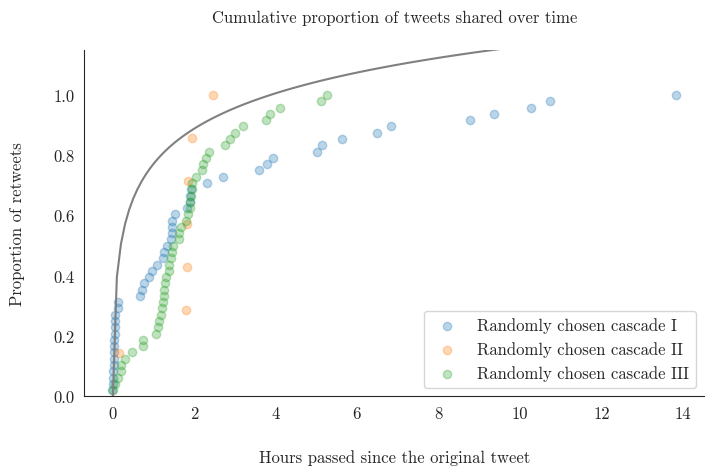

In [328]:
###### Plot logarithmic 'viral' cascades  #####

# Generate x values
x_values = np.linspace(0.01, 10, 100)  # Avoid log(0) by starting from a small value

# Calculate y values using the logarithmic function
y_values = a * np.log(x_values) + b

plt.close()
plt.figure(figsize=(16/2,9/2))
# Generate and plot scatterplots for 4 random tweet IDs
for _ in range(3):
    tweet_id = pick_random_tweet_id(viral_cascades)
    x = viral_cascades.loc[tweet_id].scaled_timestamps[1:]
    y = np.linspace(0, 1, len(x)+1)[1:]
    plt.scatter(x, y, label=f'Tweet ID: {tweet_id}', alpha=0.3)

# Plot the original data and the fitted curve


#plt.scatter(x, y, label='Original Data',facecolor='None',edgecolor='gray')
plt.plot(x_values, y_values, '-', label='Fitted Logarithmic Curve',color='gray')
plt.xlabel('Hours passed since the original tweet',labelpad=20)
plt.ylabel('Proportion of retweets',labelpad=20)
plt.title('Cumulative proportion of tweets shared over time',pad=20)

plt.legend(['Randomly chosen cascade I','Randomly chosen cascade II', 'Randomly chosen cascade III'],loc='lower right')
plt.ylim([0,1.15])

# Remove the top and right spines for a cleaner appearance
sns.despine()

# Save the plot as an SVG file
#plt.savefig('/Users/ekinderdiyok/Documents/Thesis/Figures/log_plot.svg', format='svg', bbox_inches='tight')

plt.show()

## Interrater agreement  <a class="anchor" id="interrater-agreement"></a>

### Topic <a class="anchor" id="topic"></a>

In [345]:
from sklearn.metrics import cohen_kappa_score

print(cascades.topic.value_counts())

i=1
for tweet in cascades.text.sample(30, random_state = 43):
    print(f'{i}: ')
    print(tweet, "\n")
    i += 1

# Enter your judgments here
human_rated = [2, 2, 7, 3, 7, 2, 6, 5, 2, 7, 4, 8, 2, 2, 2, 3, 6, 4, 10, 4, 9, 7, 4, 3, 6, 6, 7, 6, 7, 7]

machine_rated = list(cascades.i_topic.sample(30, random_state = 42))
machine_rated = [int(element) for element in machine_rated]
machine_rated



# Compute Cohen's Kappa
kappa = cohen_kappa_score(human_rated, machine_rated)
print(f"Cohen's Kappa: {kappa}")

7. Relief efforts, resources, donations, and infrastructure    229
2. Impact, aftermath, death toll                                98
4. International response and international support             79
6. Controversy, criticism, social and political commentary      58
1. Rescue operations and assistance                             30
8. Faith and prayers                                            30
9. Personal experience, stories, and missing people             27
3. Aftershocks and tremors                                      23
5. Technology, communication, and social media                  19
The tweet does not fit any of the given topics.                 12
Name: topic, dtype: int64
UPDATED: Death Toll From Nepal Quake Passes 2,200 as Aftershocks Terrorize Capital http://nyti.ms/1HGT6WD 

Devastating 7.9 #NepalEarthquake impacting the area around Kathmandu. Children+families at risk - help now: http://bit.ly/1GsM5Hf 

DSGMC and SGPC have announced to send food packets for #NepalEar

### Nature <a class="anchor" id="nature"></a>

In [442]:
print(cascades.topic.value_counts())

i=1
for tweet in cascades.text.sample(30, random_state = 43):
    print(f'{i}: ')
    print(tweet, "\n")
    i += 1

# Enter your judgments here
human_rated = [1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0,0,0,1,0, 0, 0,1,0,1,0,0,0,0,0,1,1,0,0,0]
len(human_rated)
# List of GPT model predictions
machine_rated = list(cascades.natures.sample(30, random_state = 43))
machine_rated = [int(element) for element in machine_rated]
machine_rated

# Compute Cohen's Kappa
kappa = cohen_kappa_score(human_rated, machine_rated)
print(f"Cohen's Kappa: {kappa}")


7. Relief efforts, resources, donations, and infrastructure    229
2. Impact, aftermath, death toll                                98
4. International response and international support             79
6. Controversy, criticism, social and political commentary      58
1. Rescue operations and assistance                             30
8. Faith and prayers                                            30
9. Personal experience, stories, and missing people             27
3. Aftershocks and tremors                                      23
5. Technology, communication, and social media                  19
The tweet does not fit any of the given topics.                 12
Name: topic, dtype: int64
1: 
@DrGPradhanThis picture shows how  @yogrishiramdev  is helping victims in Nepal #EarthquakeAgain ..#Respect  @DrGPradhan 

2: 
How has the #NepalQuake affected the country's most vulnerable -- its children? I talk to  @unicef_nepal 's Rupa Joshi 5pHKT  @CNNi  #Nepal 

3: 
First IAF plane carrying 3.